In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score

# Load dataset
file_path = r"C:\Users\91630\OneDrive\cloudcomputing\cc_project\vmCloud_data.csv"
df = pd.read_csv(file_path)

# Preprocessing
# Fill missing values for numeric columns with their mean
df["cpu_usage"] = df["cpu_usage"].fillna(df["cpu_usage"].mean())
df["memory_usage"] = df["memory_usage"].fillna(df["memory_usage"].mean())
df["task_type"] = df["task_type"].fillna("unknown")
df["task_priority"] = df["task_priority"].fillna("low")

# One-hot encoding for categorical features
encoder = OneHotEncoder(sparse_output=False, drop="first")  # Updated parameter name
encoded_features = encoder.fit_transform(df[["task_type", "task_priority"]])
encoded_df = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(["task_type", "task_priority"]))

# Combine encoded features with original dataframe
df = pd.concat([df, encoded_df], axis=1)

# Select features and targets for prediction
features = ["power_consumption", "num_executed_instructions", "execution_time"] + list(encoded_df.columns)
X = df[features]
y_cpu = df["cpu_usage"]
y_memory = df["memory_usage"]
# Handle missing values in feature columns by filling with the mean
X = df[features].fillna(df[features].mean())

# Split into train and test sets
X_train_cpu, X_test_cpu, y_train_cpu, y_test_cpu = train_test_split(X, y_cpu, test_size=0.2, random_state=42)
X_train_memory, X_test_memory, y_train_memory, y_test_memory = train_test_split(X, y_memory, test_size=0.2, random_state=42)

# Train linear regression models
cpu_model = LinearRegression()
cpu_model.fit(X_train_cpu, y_train_cpu)

memory_model = LinearRegression()
memory_model.fit(X_train_memory, y_train_memory)

# Evaluation for CPU usage
cpu_predictions = cpu_model.predict(X_test_cpu)
cpu_mse = mean_squared_error(y_test_cpu, cpu_predictions)
cpu_r2 = r2_score(y_test_cpu, cpu_predictions)

# Evaluation for Memory usage
memory_predictions = memory_model.predict(X_test_memory)
memory_mse = mean_squared_error(y_test_memory, memory_predictions)
memory_r2 = r2_score(y_test_memory, memory_predictions)

print(f"CPU Usage Model - MSE: {cpu_mse}, R2: {cpu_r2}")
print(f"Memory Usage Model - MSE: {memory_mse}, R2: {memory_r2}")


# Input for prediction
def predict_usage(power_consumption, num_executed_instructions, execution_time, task_type, task_priority):
    # Prepare input data
    input_data = pd.DataFrame([{
        "power_consumption": power_consumption,
        "num_executed_instructions": num_executed_instructions,
        "execution_time": execution_time
    }])
    task_type_encoded = encoder.transform([[task_type, task_priority]])[0]
    input_encoded = pd.DataFrame([task_type_encoded], columns=encoder.get_feature_names_out(["task_type", "task_priority"]))
    input_data = pd.concat([input_data, input_encoded], axis=1)
    
    # Ensure all feature columns are present
    input_data = input_data.reindex(columns=features, fill_value=0)
    
    # Predict
    predicted_cpu = cpu_model.predict(input_data)[0]
    predicted_memory = memory_model.predict(input_data)[0]
    return predicted_cpu, predicted_memory
average_power_consumption = df["power_consumption"].mean()
print(f"Average Power Consumption: {average_power_consumption}")
max_power_consumption = df["power_consumption"].max()
print(f"Max Power Consumption: {max_power_consumption}")
min_power_consumption = df["power_consumption"].min()
print(f"Min Power Consumption: {min_power_consumption}")
average_execution_time = df["execution_time"].mean()
print(f"Average execution Time : {average_execution_time}")
max_execution_time = df["execution_time"].max()
print(f"Max execution Time {max_execution_time}")
min_execution_time = df["execution_time"].min()
print(f"mIN EXECUTION TIME : {min_execution_time}")
average_eexecuted_instructions = df["num_executed_instructions"].mean()
print(f"mean no of execution instructions: {average_eexecuted_instructions}")
max_execution_time_max = df["num_executed_instructions"].max()
print(f"Max no of execution instructions: {max_execution_time_max}")
min_execution_time_max = df["num_executed_instructions"].max()
print(f"Min no of execution instructions: {min_execution_time_max}")
# Example prediction
power_consumption = 100000
num_executed_instructions = 60
execution_time = 20
task_type = "io"
task_priority = "low"

predicted_cpu, predicted_memory = predict_usage(power_consumption, num_executed_instructions, execution_time, task_type, task_priority)
print(f"Predicted CPU Usage: {predicted_cpu}")
print(f"Predicted Memory Usage: {predicted_memory}")


In [ ]:
# Block 1: Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import seaborn as sns

# Block 2: Data Loading and Preprocessing
Cloud_data = pd.read_csv(r"C:\Users\91630\OneDrive\cloudcomputing\cc_project\vmCloud_data.csv")  # Replace with your dataset

# Handling missing values
columns_to_fill = ['cpu_usage', 'memory_usage', 'network_traffic', 'power_consumption',
                   'num_executed_instructions', 'execution_time', 'energy_efficiency']
for col in columns_to_fill:
    Cloud_data[col].fillna(Cloud_data[col].mean(), inplace=True)

# Convert categorical columns to category dtype
categorical_columns = ['task_type', 'task_priority', 'task_status']
for col in categorical_columns:
    Cloud_data[col] = Cloud_data[col].astype('category')

# Convert timestamp to datetime
Cloud_data['timestamp'] = pd.to_datetime(Cloud_data['timestamp'])

# Block 3: Feature Engineering
# Creating Lag Features
for lag in range(1, 4):
    Cloud_data[f'cpu_usage_lag{lag}'] = Cloud_data['cpu_usage'].shift(lag)
    Cloud_data[f'memory_usage_lag{lag}'] = Cloud_data['memory_usage'].shift(lag)

# Rolling Averages
Cloud_data['cpu_usage_7d_avg'] = Cloud_data['cpu_usage'].rolling(window=7, min_periods=1).mean()
Cloud_data['memory_usage_7d_avg'] = Cloud_data['memory_usage'].rolling(window=7, min_periods=1).mean()

# Dropping rows with NaN values caused by lag features
Cloud_data.dropna(inplace=True)

# Block 4: Feature Selection and Data Splitting
X = Cloud_data[['cpu_usage_lag1', 'cpu_usage_lag2', 'cpu_usage_lag3', 
                'memory_usage_lag1', 'memory_usage_lag2', 'memory_usage_lag3', 
                'cpu_usage_7d_avg', 'memory_usage_7d_avg', 'num_executed_instructions', 
                'execution_time', 'energy_efficiency']]
y = Cloud_data['cpu_usage']

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Block 5: Model Building and Training
regressor = LinearRegression()
regressor.fit(X_train, y_train)

# Block 6: Predictions and Evaluation
y_pred = regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"R-Squared: {r2}")

# Block 7: Visualization (Weekly Trends)
Cloud_data['week'] = Cloud_data['timestamp'].dt.to_period('W')
weekly_usage = Cloud_data.groupby('week')['cpu_usage'].mean()
plt.figure(figsize=(10, 6))
weekly_usage.plot(kind='line', marker='o', title="Weekly Average CPU Usage")
plt.ylabel("CPU Usage")
plt.show()

# Monthly Trends
Cloud_data['month'] = Cloud_data['timestamp'].dt.to_period('M')
monthly_usage = Cloud_data.groupby('month')['cpu_usage'].mean()
plt.figure(figsize=(10, 6))
monthly_usage.plot(kind='line', marker='o', title="Monthly Average CPU Usage", color='orange')
plt.ylabel("CPU Usage")
plt.show()

# Yearly Trends
Cloud_data['year'] = Cloud_data['timestamp'].dt.to_period('Y')
yearly_usage = Cloud_data.groupby('year')['cpu_usage'].mean()
plt.figure(figsize=(10, 6))
yearly_usage.plot(kind='line', marker='o', title="Yearly Average CPU Usage", color='green')
plt.ylabel("CPU Usage")
plt.show()

# Block 8: Feature Importance
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': regressor.coef_
}).sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importance)
plt.title('Feature Importance for CPU Usage Prediction')
plt.show()

# Block 9: Future Predictions (Weekly, Monthly, Yearly)
future_week = regressor.predict(X_test.tail(7))  # Predicting for 1 week
future_month = regressor.predict(X_test.tail(30))  # Predicting for 1 month
future_year = regressor.predict(X_test.tail(365))  # Predicting for 1 year

print(f"Predicted CPU Usage (Weekly): {future_week}")
print(f"Predicted CPU Usage (Monthly): {future_month}")
print(f"Predicted CPU Usage (Yearly): {future_year}")


In [ ]:
import joblib

# Save the models to disk
joblib.dump(cpu_model, "cpu_model.pkl")
joblib.dump(memory_model, "memory_model.pkl")

# Save the encoder (if you need to use it for encoding new inputs later)
joblib.dump(encoder, "encoder.pkl")


In [ ]:
import joblib
import pandas as pd

# Load the saved models
cpu_model = joblib.load("cpu_model.pkl")
memory_model = joblib.load("memory_model.pkl")
encoder = joblib.load("encoder.pkl")

# Define the VM class
class VirtualMachine:
    def __init__(self, id, max_cpu, max_memory):
        self.id = id
        self.max_cpu = max_cpu
        self.max_memory = max_memory
        self.remaining_cpu = max_cpu
        self.remaining_memory = max_memory

    def allocate_task(self, predicted_cpu, predicted_memory):
        if self.remaining_cpu >= predicted_cpu and self.remaining_memory >= predicted_memory:
            self.remaining_cpu -= predicted_cpu
            self.remaining_memory -= predicted_memory
            return True
        return False

# Define the Task class
class Task:
    def __init__(self, power_consumption, num_executed_instructions, execution_time, task_type, task_priority):
        self.power_consumption = power_consumption
        self.num_executed_instructions = num_executed_instructions
        self.execution_time = execution_time
        self.task_type = task_type
        self.task_priority = task_priority

    def predict_usage(self):
        # Prepare input data for prediction
        input_data = pd.DataFrame([{
            "power_consumption": self.power_consumption,
            "num_executed_instructions": self.num_executed_instructions,
            "execution_time": self.execution_time
        }])
        task_type_encoded = encoder.transform([[self.task_type, self.task_priority]])[0]
        input_encoded = pd.DataFrame([task_type_encoded], columns=encoder.get_feature_names_out(["task_type", "task_priority"]))
        input_data = pd.concat([input_data, input_encoded], axis=1)

        # Ensure all feature columns are present
        input_data = input_data.reindex(columns=features, fill_value=0)
        
        # Predict CPU and Memory usage
        predicted_cpu = cpu_model.predict(input_data)[0]
        predicted_memory = memory_model.predict(input_data)[0]
        return predicted_cpu, predicted_memory


In [ ]:
import random
import matplotlib.pyplot as plt

# Create some sample VMs
vms = [VirtualMachine(id=i, max_cpu=120, max_memory=300) for i in range(5)]  # 5 VMs with 150 CPU and 150 memory each

# List to track task allocation over time
task_allocations = []

# Function to allocate tasks to VMs
def allocate_task_to_vm(task):
    # Print task information first
    print(f"Task Info - Power Consumption: {task.power_consumption}, Num Executed Instructions: {task.num_executed_instructions}, Execution Time: {task.execution_time}, Task Type: {task.task_type}, Task Priority: {task.task_priority}")
    
    predicted_cpu, predicted_memory = task.predict_usage()
    print(f"Predicted CPU Usage: {predicted_cpu}, Predicted Memory Usage: {predicted_memory}")
    
    # Try to allocate the task to a VM
    allocated = False
    for vm in vms:
        if vm.allocate_task(predicted_cpu, predicted_memory):
            print(f"Task allocated to VM {vm.id}")
            allocated = True
            # Record the task allocation
            task_allocations.append(vm.id)
            break
    
    if not allocated:
        print("Task could not be allocated. No VM has enough resources.")
        task_allocations.append(None)  # None if no VM was available

# Function to plot VM resource allocation (at the end)
def plot_vm_status():
    vm_ids = [vm.id for vm in vms]
    remaining_cpu = [vm.remaining_cpu for vm in vms]
    remaining_memory = [vm.remaining_memory for vm in vms]

    fig, ax = plt.subplots()
    bar_width = 0.35
    index = range(len(vms))

    bar1 = ax.bar(index, remaining_cpu, bar_width, label='Remaining CPU')
    bar2 = ax.bar([i + bar_width for i in index], remaining_memory, bar_width, label='Remaining Memory')

    ax.set_xlabel('VM ID')
    ax.set_ylabel('Resources')
    ax.set_title('VM Resource Allocation Status')
    ax.set_xticks([i + bar_width / 2 for i in index])
    ax.set_xticklabels([str(i) for i in vm_ids])
    ax.legend()

    plt.tight_layout()
    plt.show()

# Function to plot the task allocation line chart (at the end)
def plot_task_allocation():
    # Plot the task allocation line chart
    plt.figure()
    plt.plot(range(len(task_allocations)), task_allocations, marker='o', color='b', linestyle='-', markersize=5)
    plt.xlabel('Task Number')
    plt.ylabel('VM Allocated')
    plt.title('Task Allocation Over Time')
    plt.xticks(range(len(task_allocations)))
    plt.grid(True)
    plt.show()

# Simulate incoming tasks
for _ in range(10):  # Simulate 10 tasks
    power_consumption = random.randint(50000, 100000)
    num_executed_instructions = random.randint(5000,10000)
    execution_time = random.randint(10, 30)
    task_type = random.choice(["io", "compute", "network"])
    task_priority = random.choice(["low", "medium", "high"])
    
    task = Task(power_consumption, num_executed_instructions, execution_time, task_type, task_priority)
    allocate_task_to_vm(task)

# After all tasks are allocated, plot the final results
plot_vm_status()
plot_task_allocation()


Task Info - Power Consumption: 114.32, Num Executed Instructions: 9759, Execution Time: 54.78, Task Type: io, Task Priority: low
Predicted CPU Usage: 50.03166448265879, Predicted Memory Usage: 49.90099158780788
Task allocated to VM 0
Task Info - Power Consumption: 270.93, Num Executed Instructions: 7455, Execution Time: 21.66, Task Type: compute, Task Priority: low
Predicted CPU Usage: 49.99009489041046, Predicted Memory Usage: 49.88174871561329
Task allocated to VM 1
Task Info - Power Consumption: 460.74, Num Executed Instructions: 1229, Execution Time: 63.41, Task Type: compute, Task Priority: medium
Predicted CPU Usage: 49.928149923520614, Predicted Memory Usage: 49.995859332330575
Task allocated to VM 2
Task Info - Power Consumption: 199.54, Num Executed Instructions: 7352, Execution Time: 6.75, Task Type: compute, Task Priority: low
Predicted CPU Usage: 50.02412378292984, Predicted Memory Usage: 49.89720280989401
Task allocated to VM 3
Task Info - Power Consumption: 70.49, Num Exe

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn

Predicted CPU Usage: 50.00378995328341, Predicted Memory Usage: 49.92705559503996
Task could not be allocated. No VM has enough resources.
Task Info - Power Consumption: 420.63, Num Executed Instructions: 4140, Execution Time: 84.12, Task Type: network, Task Priority: low
Predicted CPU Usage: 50.00595857403567, Predicted Memory Usage: 49.91922548788404
Task could not be allocated. No VM has enough resources.
Task Info - Power Consumption: 396.57, Num Executed Instructions: 106, Execution Time: 31.83, Task Type: io, Task Priority: medium
Predicted CPU Usage: 50.01704939473985, Predicted Memory Usage: 50.141648659011764
Task could not be allocated. No VM has enough resources.
Task Info - Power Consumption: 92.49, Num Executed Instructions: 7766, Execution Time: 65.3, Task Type: io, Task Priority: high
Predicted CPU Usage: 49.97701406960711, Predicted Memory Usage: 49.98170741233102
Task could not be allocated. No VM has enough resources.
Task Info - Power Consumption: 165.25, Num Execute

c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn(
c:\Python312\Lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but OneHotEncoder was fitted with feature names
  warnings.warn

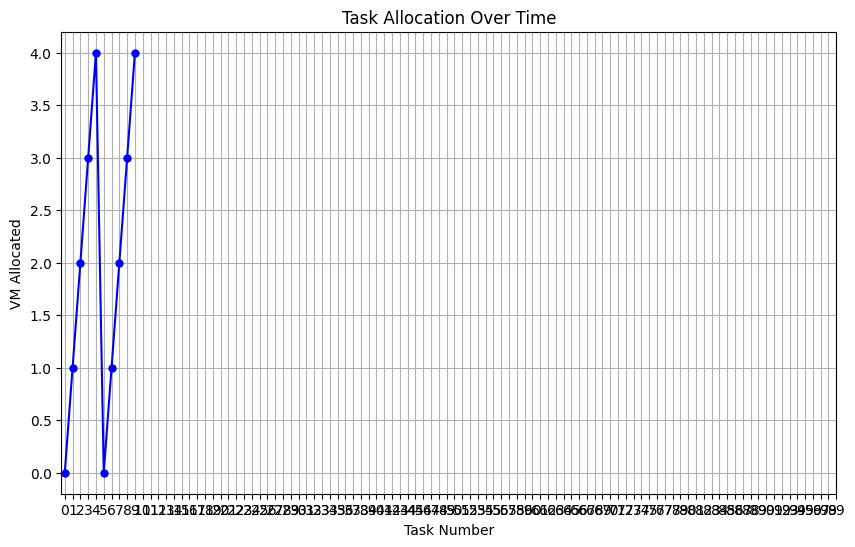

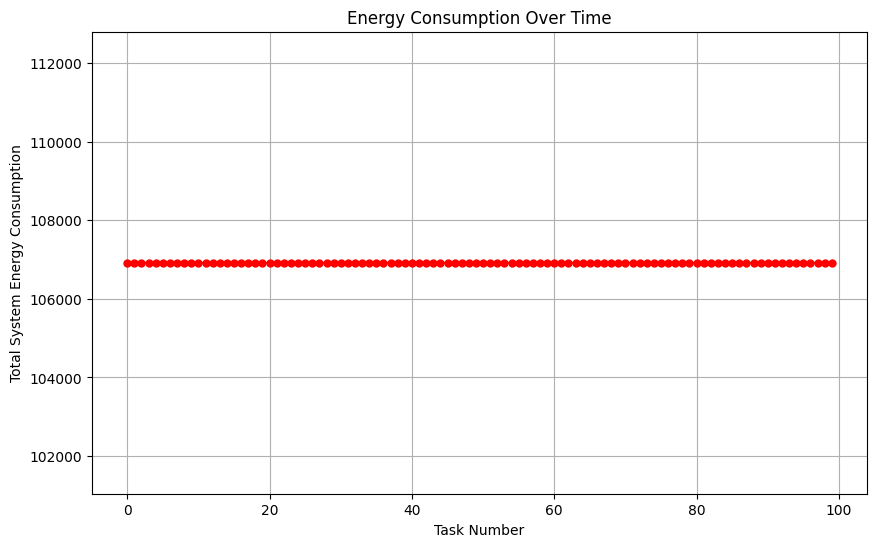

Total System Energy Consumption: 106919.3663


In [38]:
import joblib
import pandas as pd
import matplotlib.pyplot as plt

# Load the saved models
cpu_model = joblib.load("cpu_model.pkl")
memory_model = joblib.load("memory_model.pkl")
encoder = joblib.load("encoder.pkl")

# Define the VM class
class VirtualMachine:
    def __init__(self, id, max_cpu, max_memory):
        self.id = id
        self.max_cpu = max_cpu
        self.max_memory = max_memory
        self.remaining_cpu = max_cpu
        self.remaining_memory = max_memory
        self.total_energy_consumed = 0  # To track energy consumption

    def allocate_task(self, predicted_cpu, predicted_memory, task):
        if self.remaining_cpu >= predicted_cpu and self.remaining_memory >= predicted_memory:
            self.remaining_cpu -= predicted_cpu
            self.remaining_memory -= predicted_memory
            energy_used = task.power_consumption * task.execution_time
            self.total_energy_consumed += energy_used
            return True, energy_used
        return False, 0

# Define the Task class
class Task:
    def __init__(self, power_consumption, num_executed_instructions, execution_time, task_type, task_priority):
        self.power_consumption = power_consumption
        self.num_executed_instructions = num_executed_instructions
        self.execution_time = execution_time
        self.task_type = task_type
        self.task_priority = task_priority

    def predict_usage(self):
        # Prepare input data for prediction
        input_data = pd.DataFrame([{
            "power_consumption": self.power_consumption,
            "num_executed_instructions": self.num_executed_instructions,
            "execution_time": self.execution_time
        }])
        task_type_encoded = encoder.transform([[self.task_type, self.task_priority]])[0]
        input_encoded = pd.DataFrame([task_type_encoded], columns=encoder.get_feature_names_out(["task_type", "task_priority"]))

        input_data = pd.concat([input_data, input_encoded], axis=1)

        # Ensure all feature columns are present
        input_data = input_data.reindex(columns=features, fill_value=0)
        
        # Predict CPU and Memory usage
        predicted_cpu = cpu_model.predict(input_data)[0]
        predicted_memory = memory_model.predict(input_data)[0]
        return predicted_cpu, predicted_memory

# Create some sample VMs
vms = [VirtualMachine(id=i, max_cpu=120, max_memory=300) for i in range(5)]  # 5 VMs with 120 CPU and 300 memory each

# List to track task allocation over time
task_allocations = []
total_system_energy = 0  # To track total energy consumption of the system

# Round-Robin task allocation index
round_robin_index = 0

# Function to allocate tasks to VMs using Round-Robin
def allocate_task_to_vm(task):
    global round_robin_index, total_system_energy
    
    # Print task information first
    print(f"Task Info - Power Consumption: {task.power_consumption}, Num Executed Instructions: {task.num_executed_instructions}, Execution Time: {task.execution_time}, Task Type: {task.task_type}, Task Priority: {task.task_priority}")
    
    predicted_cpu, predicted_memory = task.predict_usage()
    print(f"Predicted CPU Usage: {predicted_cpu}, Predicted Memory Usage: {predicted_memory}")
    
    # Try to allocate the task using Round-Robin
    allocated = False
    task_energy_consumed = 0
    for i in range(len(vms)):
        vm = vms[(round_robin_index + i) % len(vms)]  # Get VM in Round-Robin order
        allocated, task_energy_consumed = vm.allocate_task(predicted_cpu, predicted_memory, task)
        if allocated:
            print(f"Task allocated to VM {vm.id}")
            task_allocations.append(vm.id)
            total_system_energy += task_energy_consumed  # Add energy used to system total
            break
    
    if not allocated:
        print("Task could not be allocated. No VM has enough resources.")
        task_allocations.append(None)  # None if no VM was available

    # Update round-robin index for next task allocation
    round_robin_index = (round_robin_index + 1) % len(vms)

# Function to plot the task allocation line chart (at the end)
def plot_task_allocation():
    # Plot the task allocation line chart
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    plt.plot(range(len(task_allocations)), task_allocations, marker='o', color='b', linestyle='-', markersize=5)
    plt.xlabel('Task Number')
    plt.ylabel('VM Allocated')
    plt.title('Task Allocation Over Time')
    plt.xticks(range(len(task_allocations)))
    plt.grid(True)
    plt.show()

# Function to plot energy consumption
def plot_energy_consumption():
    # Plot the energy consumption over time
    plt.figure(figsize=(10, 6))  # Adjust the figure size
    plt.plot(range(len(task_allocations)), [total_system_energy] * len(task_allocations), color='r', linestyle='-', marker='o', markersize=5)
    plt.xlabel('Task Number')
    plt.ylabel('Total System Energy Consumption')
    plt.title('Energy Consumption Over Time')
    plt.grid(True)
    plt.show()

# Predefined tasks (replacing the random task generation)
tasks = [
    Task(114.32, 9759, 54.78, "io", "low"),
    Task(270.93, 7455, 21.66, "compute", "low"),
    Task(460.74, 1229, 63.41, "compute", "medium"),
    Task(199.54, 7352, 6.75, "compute", "low"),
    Task(70.49, 7857, 46.94, "network", "high"),
    Task(85.71, 2407, 55.19, "io", "high"),
    Task(422.07, 8707, 36.33, "io", "medium"),
    Task(475.58, 3097, 35.04, "network", "medium"),
    Task(180.51, 7326, 11.01, "compute", "medium"),
    Task(424.99, 4117, 52.24, "network", "medium"),
    Task(430.4, 1504, 54.39, "network", "low"),
    Task(10.18, 2223, 0.76, "network", "high"),
    Task(9.65, 6044, 63.34, "compute", "low"),
    Task(322.32, 6217, 78.3, "compute", "low"),
    Task(130.36, 2151, 21.3, "network", "high"),
    Task(253.7, 6352, 84.15, "compute", "medium"),
    Task(281.57, 6498, 90.77, "compute", "low"),
    Task(42.89, 9675, 77.85, "network", "medium"),
    Task(390.12, 6109, 62.95, "network", "low"),
    Task(225.47, 608, 95.35, "io", "medium"),
    Task(173.4, 1669, 41.51, "network", "medium"),
    Task(315.47, 6732, 17.93, "compute", "low"),
    Task(232.48, 7639, 9.98, "io", "low"),
    Task(493.7, 671, 1.91, "compute", "medium"),
    Task(95.19, 2148, 5.19, "compute", "medium"),
    Task(394.99, 9370, 31.39, "io", "low"),
    Task(310.82, 4586, 78.65, "compute", "medium"),
    Task(433.26, 409, 72.37, "io", "high"),
    Task(447.78, 9375, 11.24, "compute", "high"),
    Task(123.58, 359, 39.38, "compute", "high"),
    Task(293.42, 3411, 69.94, "io", "medium"),
    Task(253.97, 1885, 29.7, "compute", "low"),
    Task(330.88, 4027, 21.44, "network", "high"),
    Task(258.09, 1264, 8.24, "compute", "medium"),
    Task(201.24, 5931, 58.45, "io", "high"),
    Task(93.65, 8043, 43.25, "network", "low"),
    Task(354.91, 598, 51.78, "io", "medium"),
    Task(477.6, 9324, 94.3, "compute", "high"),
    Task(372.42, 7783, 1.98, "network", "high"),
    Task(349.45, 7139, 10.02, "network", "low"),
    Task(152.22, 6687, 12.32, "io", "low"),
    Task(290.9, 9424, 24.49, "network", "low"),
    Task(429.25, 5963, 3.27, "io", "medium"),
    Task(196.61, 1045, 38.0, "io", "high"),
    Task(474.12, 3100, 47.28, "io", "high"),
    Task(92.08, 6484, 0.13, "compute", "medium"),
    Task(59.18, 841, 94.68, "io", "high"),
    Task(66.58, 3952, 92.92, "network", "high"),
    Task(446.71, 1943, 48.7, "io", "low"),
    Task(428.19, 2526, 87.02, "io", "medium"),
    Task(169.22, 6567, 87.93, "io", "high"),
    Task(116.96, 1347, 72.14, "network", "high"),
    Task(36.46, 5269, 79.96, "network", "high"),
    Task(396.42, 3903, 36.69, "io", "medium"),
    Task(334.22, 3153, 72.13, "io", "low"),
    Task(137.59, 1216, 8.74, "network", "high"),
    Task(456.59, 3362, 16.98, "compute", "low"),
    Task(229.06, 6381, 12.7, "io", "medium"),
    Task(276.19, 3902, 47.8, "compute", "high"),
    Task(77.71, 5122, 61.86, "compute", "high"),
    Task(330.38, 6360, 3.09, "io", "high"),
    Task(189.99, 2674, 95.98, "network", "low"),
    Task(184.38, 9867, 10.23, "compute", "high"),
    Task(166.01, 5303, 30.38, "compute", "high"),
    Task(336.67, 7313, 1.93, "network", "high"),
    Task(131.03, 2788, 3.02, "network", "low"),
    Task(110.91, 3063, 33.46, "network", "low"),
    Task(236.83, 7602, 29.77, "network", "high"),
    Task(445.91, 6773, 27.22, "compute", "medium"),
    Task(296.23, 4706, 42.3, "io", "low"),
    Task(362.05, 4195, 25.62, "compute", "low"),
    Task(420.63, 4140, 84.12, "network", "low"),
    Task(396.57, 106, 31.83, "io", "medium"),
    Task(92.49, 7766, 65.3, "io", "high"),
    Task(165.25, 1246, 40.08, "network", "low"),
    Task(180.63, 4142, 14.61, "network", "high"),
    Task(62.28, 7924, 94.21, "network", "high"),
    Task(181.03, 9859, 30.87, "compute", "low"),
    Task(275.7, 3582, 45.59, "compute", "high"),
    Task(28.33, 708, 49.45, "io", "high"),
    Task(378.36, 6358, 62.79, "compute", "medium"),
    Task(336.91, 7295, 72.45, "io", "low"),
    Task(401.2, 3413, 15.89, "network", "low"),
    Task(283.23, 6799, 89.01, "network", "medium"),
    Task(125.82, 9199, 98.86, "io", "medium"),
    Task(86.34, 10, 23.31, "compute", "medium"),
    Task(42.45, 530, 42.46, "io", "low"),
    Task(492.6, 2664, 43.5, "network", "high"),
    Task(307.28, 1737, 72.33, "compute", "high"),
    Task(241.55, 4222, 98.43, "compute", "high"),
    Task(227.27, 8123, 39.2, "network", "low"),
    Task(391.72, 8292, 97.14, "compute", "medium"),
    Task(112.01, 2437, 66.5, "io", "low"),
    Task(11.23, 5365, 4.5, "io", "low"),
    Task(158.11, 7817, 54.77, "compute", "medium"),
    Task(319.97, 4374, 4.63, "network", "medium"),
    Task(171.09, 8760, 62.84, "network", "medium"),
    Task(140.97, 2390, 50.54, "io", "low"),
    Task(436.88, 2061, 63.96, "compute", "low"),
    Task(170.31, 6603, 39.73, "compute", "high"),
]
 # Replace with more tasks as needed

# Simulate task allocation
for task in tasks:  # Iterate over predefined tasks
    allocate_task_to_vm(task)

# After all tasks are allocated, plot the task allocation chart
plot_task_allocation()

# After all tasks are allocated, plot energy consumption chart
plot_energy_consumption()

# Print total system energy consumption
print(f"Total System Energy Consumption: {total_system_energy}")


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import OneHotEncoder

# Load the pre-trained models for CPU and Memory prediction
cpu_model = joblib.load("cpu_model.pkl")
memory_model = joblib.load("memory_model.pkl")
encoder = joblib.load("encoder.pkl")  # Encoder to transform task attributes

# Define VirtualMachine and Task classes
class VirtualMachine:
    def __init__(self, id, max_cpu, max_memory, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.id = id
        self.max_cpu = max_cpu
        self.max_memory = max_memory
        self.remaining_cpu = max_cpu
        self.remaining_memory = max_memory
        self.total_energy_consumed = 0
        self.dynamic_threshold = 0 
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}  # Q-table to store state-action values
        self.priority_weights = {"low": 0, "medium": 1, "high": 2}  # Priority weights
    
    def get_state(self):
        return (self.remaining_cpu, self.remaining_memory, self.total_energy_consumed)
    def calculate_dynamic_threshold(self):
        # Example of dynamic threshold calculation based on resource usage
        utilization_factor = (self.max_cpu - self.remaining_cpu) / self.max_cpu
        self.dynamic_threshold = 12500 * (1 + utilization_factor)  # Adjust threshold
    
    def choose_action(self, state, possible_actions):
        """Epsilon-greedy policy for action selection"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(possible_actions)  # Exploration
        else:
            q_values = self.q_table.get(state, [0] * len(possible_actions))
            return max(range(len(q_values)), key=lambda x: q_values[x])
    
    def update_q_table(self, state, action, reward, next_state, possible_actions):
        """Update Q-value using the Q-learning equation"""
        current_q_value = self.q_table.get(state, [0] * len(possible_actions))[action]
        max_next_q_value = max(self.q_table.get(next_state, [0] * len(possible_actions)))
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * max_next_q_value - current_q_value)
        
        if state not in self.q_table:
            self.q_table[state] = [0] * len(possible_actions)
        
        self.q_table[state][action] = new_q_value

    def allocate_task(self, predicted_cpu, predicted_memory, task):
        state = self.get_state()
        possible_actions = [0, 1]  # 0: Reject task, 1: Accept task
        
        action = self.choose_action(state, possible_actions)
        
        if action == 1:
            # Check if enough resources are available
            if self.remaining_cpu < predicted_cpu or self.remaining_memory < predicted_memory:
                return False, 0  # Reject task due to insufficient resources

            task_priority_weight = self.priority_weights[task.task_priority]
            
            # Allocate task if resources are sufficient
            self.remaining_cpu -= predicted_cpu
            self.remaining_memory -= predicted_memory
            energy_used = task.power_consumption * task.execution_time * task_priority_weight
            self.total_energy_consumed += energy_used
            
            # Reward shaping: Provide a positive reward for low energy consumption
            if energy_used < self.dynamic_threshold:  # Example threshold for energy efficiency
                reward = -energy_used + 10  # Reward for efficient energy use
            else:
                reward = -energy_used  # Penalize if energy consumption is high
            
            next_state = self.get_state()
            self.update_q_table(state, action, reward, next_state, possible_actions)
            return True, energy_used
        
        # Reject task or not enough resources
        reward = -10  # Large negative reward for failure to allocate
        next_state = self.get_state()
        self.update_q_table(state, 0, reward, next_state, possible_actions)
        return False, 0


class Task:
    def __init__(self, task_id, task_priority, task_type, power_consumption, execution_time, num_executed_instructions):
        self.task_id = task_id
        self.task_priority = task_priority  # 'low', 'medium', 'high'
        self.task_type = task_type  # 'io', 'compute', 'network'
        self.power_consumption = power_consumption  # Energy consumption per unit time
        self.execution_time = execution_time  # Time the task takes to execute
        self.num_executed_instructions = num_executed_instructions  # Number of instructions for the task

    def predict_usage(self):
        # Prepare input data for prediction
        input_data = pd.DataFrame([{
            "power_consumption": self.power_consumption,
            "num_executed_instructions": self.num_executed_instructions,
            "execution_time": self.execution_time
        }])
        task_type_encoded = encoder.transform([[self.task_type, self.task_priority]])[0]
        input_encoded = pd.DataFrame([task_type_encoded], columns=encoder.get_feature_names_out(["task_type", "task_priority"]))

        input_data = pd.concat([input_data, input_encoded], axis=1)

        # Ensure all feature columns are present
        input_data = input_data.reindex(columns=features, fill_value=0)
        
        # Predict CPU and Memory usage
        predicted_cpu = cpu_model.predict(input_data)[0]
        predicted_memory = memory_model.predict(input_data)[0]
        return predicted_cpu, predicted_memory


# Function to define a task with all required attributes
def define_task(task_id, task_priority, task_type, power_consumption, execution_time, num_executed_instructions):
    return Task(task_id, task_priority, task_type, power_consumption, execution_time, num_executed_instructions)

# Create multiple VMs
vms = [VirtualMachine(id=i, max_cpu=120, max_memory=300) for i in range(100)]  # 5 VMs with 120 CPU and 300 memory each

# Predefined tasks with integer values for attributes other than cpu_required and memory_required
tasks = [
    define_task(0, "high", "io", 450.07, 98.43, 7936),
    define_task(1, "low", "compute", 247.34, 3.23, 2590),
    define_task(2, "high", "compute", 399.32, 72.37, 1250),
    define_task(3, "low", "network", 116.82, 5.43, 4718),
    define_task(4, "low", "network", 132.42, 66.87, 6403),
    define_task(5, "high", "network", 160.06, 45.33, 5847),
    define_task(6, "low", "io", 5.06, 98.29, 7966),
    define_task(7, "low", "compute", 367.84, 98.48, 2993),
    define_task(8, "medium", "network", 159.95, 55.93, 4635),
    define_task(9, "medium", "network", 36.83, 70.97, 6306),
    define_task(10, "low", "compute", 439.55, 67.54, 6252),
    define_task(11, "high", "network", 366.03, 46.88, 9331),
    define_task(12, "low", "compute", 4.97, 6.28, 6391),
    define_task(13, "high", "compute", 431.42, 56.81, 1796),
    define_task(14, "medium", "network", 459.71, 92.32, 602),
    define_task(15, "low", "compute", 470.36, 78.35, 999),
    define_task(16, "high", "compute", 128.05, 70.58, 6868),
    define_task(17, "low", "io", 259.29, 6.19, 7891),
    define_task(18, "low", "compute", 186.36, 30.97, 9139),
    define_task(19, "high", "network", 161.4, 83.6, 6780),
    define_task(20, "medium", "io", 13.19, 31.66, 4424),
    define_task(21, "high", "compute", 204.37, 59.6, 9367),
    define_task(22, "high", "network", 225.05, 75.65, 4961),
    define_task(23, "medium", "compute", 338.22, 81.55, 7349),
    define_task(24, "low", "network", 309.61, 94.57, 8428),
    define_task(25, "medium", "network", 387.55, 71.71, 8699),
    define_task(26, "medium", "network", 421.84, 2.5, 2521),
    define_task(27, "high", "io", 350.97, 12.53, 3538),
    define_task(28, "high", "io", 277.28, 35.74, 3207),
    define_task(29, "medium", "io", 63.97, 26.29, 7018),
    define_task(30, "high", "io", 89.35, 81.93, 7344),
    define_task(31, "medium", "network", 1.53, 17.48, 182),
    define_task(32, "medium", "io", 293.83, 70.36, 8959),
    define_task(33, "low", "network", 368.94, 60.76, 4234),
    define_task(34, "medium", "network", 5.84, 5.33, 1806),
    define_task(35, "low", "network", 310.34, 59.1, 8655),
    define_task(36, "high", "io", 106.08, 25.17, 5543),
    define_task(37, "high", "network", 433.17, 47.98, 4699),
    define_task(38, "high", "network", 475.91, 11.26, 8556),
    define_task(39, "medium", "compute", 280.12, 19.78, 5782),
    define_task(40, "low", "compute", 192.16, 15.33, 4324),
    define_task(41, "medium", "io", 464.87, 83.16, 3791),
    define_task(42, "medium", "io", 1.36, 59.11, 7769),
    define_task(43, "high", "compute", 208.35, 61.74, 3269),
    define_task(44, "low", "io", 312.74, 24.72, 6702),
    define_task(45, "medium", "compute", 18.69, 30.85, 9215),
    define_task(46, "low", "io", 155.93, 70.77, 2258),
    define_task(47, "low", "compute", 476.87, 53.81, 5393),
    define_task(48, "medium", "network", 248.21, 95.91, 8876),
    define_task(49, "low", "network", 322.88, 45.27, 8101),
    define_task(50, "low", "io", 32.65, 85.38, 2199),
    define_task(51, "high", "io", 113.68, 23.06, 7909),
    define_task(52, "high", "compute", 432.89, 20.78, 87),
    define_task(53, "high", "compute", 313.55, 71.63, 6206),
    define_task(54, "medium", "io", 359.07, 37.0, 5205),
    define_task(55, "medium", "compute", 488.4, 60.31, 7897),
    define_task(56, "high", "network", 341.59, 53.5, 8102),
    define_task(57, "medium", "io", 220.3, 8.24, 3380),
    define_task(58, "medium", "io", 188.47, 30.96, 2247),
    define_task(59, "low", "io", 361.63, 63.87, 6420),
    define_task(60, "medium", "io", 243.84, 59.7, 7911),
    define_task(61, "high", "io", 215.86, 89.24, 8389),
    define_task(62, "medium", "network", 374.29, 23.88, 9206),
    define_task(63, "low", "network", 175.94, 38.85, 5122),
    define_task(64, "high", "network", 18.96, 60.81, 4187),
    define_task(65, "medium", "network", 434.7, 90.45, 860),
    define_task(66, "high", "compute", 127.64, 11.26, 9296),
    define_task(67, "high", "compute", 268.07, 30.56, 3329),
    define_task(68, "low", "io", 136.89, 94.09, 8583),
    define_task(69, "low", "network", 400.91, 16.5, 8276),
    define_task(70, "medium", "io", 323.4, 9.85, 6059),
    define_task(71, "high", "network", 360.02, 26.61, 3784),
    define_task(72, "low", "compute", 186.9, 77.96, 90),
    define_task(73, "high", "compute", 365.38, 42.06, 6692),
    define_task(74, "high", "network", 359.21, 49.61, 4932),
    define_task(75, "medium", "io", 67.64, 28.22, 8154),
    define_task(76, "low", "io", 403.23, 17.03, 6707),
    define_task(77, "low", "io", 32.79, 74.74, 7312),
    define_task(78, "medium", "io", 48.88, 83.08, 6611),
    define_task(79, "low", "io", 401.01, 5.0, 2843),
    define_task(80, "low", "io", 402.05, 76.18, 5060),
    define_task(81, "low", "io", 80.55, 0.92, 9831),
    define_task(82, "low", "compute", 156.53, 33.99, 4335),
    define_task(83, "low", "compute", 210.83, 85.41, 693),
    define_task(84, "high", "compute", 444.51, 5.68, 2519),
    define_task(85, "low", "io", 337.15, 46.82, 1934),
    define_task(86, "low", "compute", 312.86, 85.98, 3920),
    define_task(87, "high", "io", 337.63, 45.98, 6275),
    define_task(88, "medium", "io", 114.98, 11.58, 5088),
    define_task(89, "medium", "io", 381.89, 98.33, 3567),
    define_task(90, "high", "compute", 350.81, 34.81, 5816),
    define_task(91, "low", "network", 382.03, 46.42, 28),
    define_task(92, "low", "compute", 200.64, 89.61, 6904),
    define_task(93, "medium", "compute", 204.94, 56.48, 9146),
    define_task(94, "medium", "io", 242.3, 35.18, 5240),
    define_task(95, "medium", "compute", 202.12, 54.35, 2881),
    define_task(96, "high", "compute", 308.41, 17.93, 1083),
    define_task(97, "medium", "io", 333.57, 15.75, 4700),
    define_task(98, "high", "network", 191.04, 90.72, 3542),
    define_task(99, "high", "io", 325.87, 91.74, 9988),
    define_task(100, "high", "network", 464.48, 72.9, 6056),
    define_task(101, "low", "compute", 277.46, 63.16, 5089),
    define_task(102, "high", "io", 396.78, 84.5, 9249),
    define_task(103, "low", "compute", 242.55, 77.24, 4125),
    define_task(104, "medium", "compute", 374.13, 7.23, 7027),
    define_task(105, "low", "network", 177.3, 84.52, 8238),
    define_task(106, "low", "compute", 459.25, 12.34, 346),
    define_task(107, "high", "network", 350.44, 73.8, 1293),
    define_task(108, "low", "network", 112.11, 54.81, 5494),
    define_task(109, "medium", "network", 495.45, 56.0, 1229),
    define_task(110, "medium", "network", 240.06, 56.26, 386),
    define_task(111, "high", "io", 258.04, 34.36, 7473),
    define_task(112, "low", "compute", 274.04, 82.86, 7510),
    define_task(113, "low", "compute", 285.49, 72.17, 5890),
    define_task(114, "low", "io", 7.45, 60.61, 9346),
    define_task(115, "medium", "compute", 442.71, 49.25, 6507),
    define_task(116, "high", "network", 66.3, 13.55, 750),
    define_task(117, "medium", "compute", 138.06, 75.64, 7868),
    define_task(118, "medium", "network", 12.35, 22.32, 1636),
    define_task(119, "medium", "network", 439.59, 23.47, 1221),
    define_task(120, "high", "compute", 27.65, 62.66, 4106),
    define_task(121, "medium", "io", 431.56, 47.7, 3334),
    define_task(122, "high", "io", 310.97, 74.91, 1611),
    define_task(123, "medium", "compute", 74.52, 10.97, 5433),
    define_task(124, "low", "io", 285.09, 18.1, 2532),
    define_task(125, "low", "io", 334.67, 56.17, 584),
    define_task(126, "low", "compute", 330.73, 82.24, 5599),
    define_task(127, "low", "network", 128.41, 22.76, 5654),
    define_task(128, "medium", "io", 166.25, 29.61, 422),
    define_task(129, "medium", "compute", 224.77, 65.58, 9660),
    define_task(130, "medium", "compute", 404.71, 71.83, 2646),
    define_task(131, "high", "io", 50.68, 32.18, 5379),
    define_task(132, "medium", "io", 217.99, 38.99, 3404),
    define_task(133, "high", "compute", 495.66, 31.28, 7313),
    define_task(134, "medium", "compute", 138.23, 72.02, 9739),
    define_task(135, "medium", "compute", 214.21, 16.84, 9988),
    define_task(136, "medium", "network", 168.86, 50.28, 2542),
    define_task(137, "low", "network", 83.88, 0.23, 2758),
    define_task(138, "medium", "io", 406.05, 45.26, 9266),
    define_task(139, "high", "network", 228.08, 48.33, 382),
    define_task(140, "low", "io", 334.25, 42.81, 3413),
    define_task(141, "medium", "io", 6.56, 17.22, 4234),
    define_task(142, "high", "network", 48.74, 63.09, 990),
    define_task(143, "high", "compute", 56.99, 36.36, 5415),
    define_task(144, "low", "network", 163.85, 28.04, 1552),
    define_task(145, "medium", "network", 495.57, 40.62, 5939),
    define_task(146, "high", "network", 206.4, 94.5, 6545),
    define_task(147, "low", "network", 142.42, 61.62, 3591),
    define_task(148, "low", "compute", 321.62, 73.44, 3369),
    define_task(149, "high", "compute", 198.97, 33.37, 2724),
    define_task(150, "low", "compute", 144.16, 86.42, 4300),
    define_task(151, "low", "compute", 386.14, 70.65, 2300),
    define_task(152, "medium", "io", 311.22, 11.25, 3578),
    define_task(153, "medium", "io", 160.02, 90.12, 1915),
    define_task(154, "low", "compute", 139.93, 15.05, 1978),
    define_task(155, "medium", "compute", 78.82, 53.04, 4304),
    define_task(156, "medium", "compute", 131.45, 70.06, 3062),
    define_task(157, "low", "network", 321.79, 22.22, 130),
    define_task(158, "high", "io", 271.55, 50.26, 2722),
    define_task(159, "low", "compute", 385.68, 10.86, 7156),
    define_task(160, "high", "compute", 20.19, 37.56, 9588),
    define_task(161, "medium", "network", 184.41, 49.3, 2245),
    define_task(162, "high", "network", 303.25, 87.42, 8798),
    define_task(163, "low", "io", 26.52, 62.59, 6662),
    define_task(164, "medium", "io", 152.56, 90.49, 3202),
    define_task(165, "medium", "network", 387.28, 61.0, 5533),
    define_task(166, "low", "io", 74.56, 94.84, 240),
    define_task(167, "medium", "io", 157.68, 92.5, 9501),
    define_task(168, "high", "compute", 343.57, 47.44, 8293),
    define_task(169, "low", "io", 157.29, 59.9, 9349),
    define_task(170, "high", "compute", 213.32, 40.17, 7545),
    define_task(171, "low", "network", 191.31, 7.67, 2327),
    define_task(172, "low", "network", 417.17, 1.76, 2982),
    define_task(173, "low", "io", 255.14, 9.22, 6668),
    define_task(174, "low", "compute", 387.85, 64.28, 7133),
    define_task(175, "high", "network", 433.92, 94.45, 7947),
    define_task(176, "low", "compute", 44.54, 88.29, 1134),
    define_task(177, "low", "network", 30.41, 68.86, 5962),
    define_task(178, "low", "compute", 476.75, 11.16, 3698),
    define_task(179, "low", "compute", 144.76, 58.27, 1774),
    define_task(180, "low", "compute", 60.13, 91.33, 1123),
    define_task(181, "low", "compute", 158.76, 48.52, 9007),
    define_task(182, "low", "network", 233.63, 45.58, 9465),
    define_task(183, "high", "compute", 485.43, 81.45, 3828),
    define_task(184, "high", "io", 309.25, 20.64, 3099),
    define_task(185, "low", "network", 414.72, 31.34, 5778),
    define_task(186, "high", "compute", 276.58, 95.05, 5334),
    define_task(187, "low", "compute", 34.79, 50.14, 6206),
    define_task(188, "medium", "network", 119.64, 31.55, 6297),
    define_task(189, "low", "network", 370.38, 68.07, 798),
    define_task(190, "medium", "compute", 114.12, 93.23, 9220),
    define_task(191, "low", "compute", 385.77, 58.61, 7864),
    define_task(192, "high", "network", 139.65, 33.17, 1630),
    define_task(193, "low", "io", 91.38, 16.88, 1078),
    define_task(194, "high", "compute", 8.95, 85.63, 3845),
    define_task(195, "high", "network", 306.85, 36.8, 8481),
    define_task(196, "medium", "network", 24.94, 28.16, 8729),
    define_task(197, "low", "compute", 22.62, 44.98, 1289),
    define_task(198, "high", "io", 340.98, 14.37, 2373),
    define_task(199, "medium", "network", 311.16, 30.86, 7393),
    define_task(200, "low", "io", 211.53, 65.29, 89),
    define_task(201, "high", "compute", 456.64, 14.76, 1893),
    define_task(202, "medium", "network", 118.78, 7.67, 4753),
    define_task(203, "medium", "io", 55.25, 67.86, 3578),
    define_task(204, "high", "io", 329.01, 32.48, 4077),
    define_task(205, "medium", "network", 268.95, 36.46, 1570),
    define_task(206, "high", "compute", 84.83, 45.85, 140),
    define_task(207, "high", "network", 149.93, 80.1, 6749),
    define_task(208, "low", "compute", 114.71, 47.22, 1214),
    define_task(209, "low", "compute", 53.43, 9.28, 1968),
    define_task(210, "high", "compute", 30.33, 38.28, 7633),
    define_task(211, "low", "network", 317.51, 49.13, 833),
    define_task(212, "medium", "io", 357.87, 93.98, 1682),
    define_task(213, "low", "compute", 108.49, 81.42, 7496),
    define_task(214, "medium", "compute", 193.94, 76.55, 3572),
    define_task(215, "low", "io", 112.79, 91.9, 8363),
    define_task(216, "medium", "io", 34.98, 95.81, 9236),
    define_task(217, "high", "network", 434.34, 87.86, 9064),
    define_task(218, "high", "network", 236.31, 16.53, 6922),
    define_task(219, "low", "network", 121.21, 91.23, 2662),
    define_task(220, "high", "network", 452.17, 7.01, 7303),
    define_task(221, "high", "io", 247.86, 30.23, 4597),
    define_task(222, "medium", "compute", 158.2, 49.38, 3766),
    define_task(223, "medium", "network", 0.72, 19.33, 5619),
    define_task(224, "high", "io", 483.01, 33.67, 3311),
    define_task(225, "high", "compute", 392.76, 90.86, 6283),
    define_task(226, "medium", "network", 329.69, 42.91, 1572),
    define_task(227, "high", "network", 453.37, 45.32, 5374),
    define_task(228, "low", "compute", 136.54, 31.32, 2113),
    define_task(229, "medium", "compute", 156.83, 63.71, 9275),
    define_task(230, "high", "io", 35.58, 88.85, 8252),
    define_task(231, "medium", "io", 349.63, 35.77, 547),
    define_task(232, "high", "network", 208.37, 79.82, 4997),
    define_task(233, "medium", "compute", 380.71, 9.69, 2592),
    define_task(234, "medium", "io", 165.77, 50.26, 4417),
    define_task(235, "low", "network", 114.96, 93.32, 1417),
    define_task(236, "low", "io", 453.74, 43.41, 5521),
    define_task(237, "medium", "io", 92.36, 84.61, 1501),
    define_task(238, "low", "io", 321.17, 2.23, 7876),
    define_task(239, "low", "io", 60.14, 34.6, 5321),
    define_task(240, "medium", "network", 499.81, 79.98, 7645),
    define_task(241, "medium", "io", 124.8, 32.74, 9455),
    define_task(242, "low", "io", 80.16, 33.36, 1729),
    define_task(243, "low", "io", 494.17, 75.83, 4579),
    define_task(244, "low", "compute", 410.0, 16.43, 7788),
    define_task(245, "high", "network", 142.13, 82.37, 686),
    define_task(246, "low", "network", 128.3, 87.66, 5359),
    define_task(247, "low", "io", 180.02, 47.9, 4172),
    define_task(248, "medium", "network", 65.42, 63.65, 9725),
    define_task(249, "low", "io", 145.75, 41.52, 8787),
    define_task(250, "medium", "compute", 147.58, 2.58, 6432),
    define_task(251, "low", "io", 433.39, 31.54, 8234),
    define_task(252, "low", "network", 414.58, 92.78, 6746),
    define_task(253, "low", "io", 425.59, 9.22, 3903),
    define_task(254, "low", "compute", 83.06, 7.72, 6640),
    define_task(255, "high", "io", 289.05, 73.4, 2585),
    define_task(256, "medium", "io", 385.51, 11.39, 2051),
    define_task(257, "high", "network", 98.06, 6.36, 4097),
    define_task(258, "low", "io", 215.71, 21.0, 4247),
    define_task(259, "medium", "io", 86.33, 45.79, 4846),
    define_task(260, "medium", "network", 314.03, 49.61, 9913),
    define_task(261, "high", "network", 344.7, 46.94, 7475),
    define_task(262, "low", "io", 335.76, 38.28, 324),
    define_task(263, "high", "io", 58.93, 85.99, 9630),
    define_task(264, "medium", "io", 296.61, 27.23, 4302),
    define_task(265, "high", "compute", 170.53, 67.53, 4725),
    define_task(266, "medium", "compute", 462.23, 23.5, 3741),
    define_task(267, "medium", "io", 417.38, 11.76, 2014),
    define_task(268, "high", "compute", 146.88, 53.5, 3952),
    define_task(269, "high", "io", 443.61, 26.3, 9436),
    define_task(270, "low", "io", 375.69, 29.67, 6824),
    define_task(271, "low", "io", 210.43, 75.86, 1495),
    define_task(272, "high", "network", 498.03, 40.17, 8483),
    define_task(273, "low", "io", 228.43, 42.04, 2637),
    define_task(274, "high", "compute", 342.76, 60.61, 3896),
    define_task(275, "high", "compute", 18.17, 93.14, 6297),
    define_task(276, "medium", "io", 373.61, 28.2, 899),
    define_task(277, "high", "compute", 2.23, 5.76, 3031),
    define_task(278, "low", "compute", 415.75, 6.7, 4980),
    define_task(279, "medium", "compute", 160.64, 39.38, 8607),
    define_task(280, "medium", "network", 318.51, 3.0, 1988),
    define_task(281, "high", "compute", 305.89, 85.25, 1982),
    define_task(282, "medium", "io", 286.65, 55.27, 5428),
    define_task(283, "low", "io", 64.48, 32.2, 8292),
    define_task(284, "low", "compute", 80.49, 89.47, 7799),
    define_task(285, "medium", "compute", 145.57, 50.23, 4733),
    define_task(286, "high", "io", 350.94, 32.53, 6962),
    define_task(287, "low", "network", 203.53, 1.55, 3312),
    define_task(288, "high", "compute", 158.68, 81.83, 9168),
    define_task(289, "low", "network", 177.58, 23.33, 8439),
    define_task(290, "high", "io", 262.97, 23.23, 1478),
    define_task(291, "medium", "network", 482.35, 52.86, 3472),
    define_task(292, "medium", "compute", 257.4, 13.51, 25),
    define_task(293, "medium", "network", 385.87, 61.54, 5525),
    define_task(294, "low", "io", 452.72, 65.71, 7624),
    define_task(295, "medium", "compute", 399.48, 25.41, 4573),
    define_task(296, "low", "compute", 338.27, 51.56, 569),
    define_task(297, "high", "io", 481.43, 68.18, 4227),
    define_task(298, "high", "network", 376.58, 39.7, 5746),
    define_task(299, "low", "network", 14.12, 65.94, 5409),
    define_task(300, "medium", "io", 330.4, 69.31, 8086),
    define_task(301, "high", "network", 465.97, 96.29, 1194),
    define_task(302, "medium", "io", 419.3, 32.16, 3981),
    define_task(303, "low", "io", 197.23, 19.57, 9095),
    define_task(304, "high", "network", 177.29, 5.93, 873),
    define_task(305, "high", "compute", 173.28, 93.7, 8596),
    define_task(306, "medium", "network", 117.29, 43.08, 7582),
    define_task(307, "medium", "compute", 488.68, 54.28, 8228),
    define_task(308, "medium", "compute", 248.04, 59.48, 1337),
    define_task(309, "high", "network", 427.73, 26.56, 446),
    define_task(310, "medium", "compute", 217.66, 60.98, 8202),
    define_task(311, "low", "network", 237.68, 67.87, 8297),
    define_task(312, "medium", "network", 322.79, 41.68, 558),
    define_task(313, "medium", "compute", 82.32, 7.9, 7780),
    define_task(314, "high", "compute", 449.65, 90.39, 255),
    define_task(315, "low", "compute", 38.69, 64.23, 4037),
    define_task(316, "medium", "compute", 245.2, 82.19, 7765),
    define_task(317, "low", "io", 238.57, 35.37, 2195),
    define_task(318, "high", "io", 343.77, 43.87, 5781),
    define_task(319, "medium", "network", 468.12, 11.84, 4198),
    define_task(320, "high", "network", 458.08, 33.53, 2116),
    define_task(321, "medium", "io", 319.65, 96.99, 2172),
    define_task(322, "high", "compute", 228.94, 20.87, 6330),
    define_task(323, "high", "compute", 84.15, 60.91, 5307),
    define_task(324, "low", "network", 454.01, 10.75, 5722),
    define_task(325, "medium", "network", 354.01, 87.03, 4714),
    define_task(326, "high", "compute", 327.17, 98.82, 1770),
    define_task(327, "medium", "network", 466.6, 58.2, 7365),
    define_task(328, "low", "compute", 120.79, 59.67, 8842),
    define_task(329, "medium", "compute", 20.85, 3.91, 4703),
    define_task(330, "medium", "network", 274.96, 65.74, 6802),
    define_task(331, "high", "network", 356.01, 92.66, 9907),
    define_task(332, "medium", "io", 320.99, 17.21, 2745),
    define_task(333, "high", "io", 69.45, 7.75, 5502),
    define_task(334, "medium", "network", 415.79, 16.38, 2926),
    define_task(335, "low", "io", 44.06, 94.5, 2045),
    define_task(336, "high", "network", 233.27, 86.27, 9916),
    define_task(337, "high", "network", 20.08, 10.97, 2383),
    define_task(338, "low", "network", 134.56, 56.5, 2019),
    define_task(339, "medium", "io", 93.7, 50.26, 3916),
    define_task(340, "high", "network", 292.85, 47.2, 7666),
    define_task(341, "low", "network", 289.91, 14.11, 2568),
    define_task(342, "low", "io", 242.2, 0.45, 9925),
    define_task(343, "low", "compute", 39.22, 90.27, 2185),
    define_task(344, "low", "io", 11.4, 70.45, 4894),
    define_task(345, "low", "compute", 115.99, 34.78, 4332),
    define_task(346, "low", "io", 216.16, 47.61, 7073),
    define_task(347, "high", "compute", 64.53, 66.35, 810),
    define_task(348, "medium", "io", 343.96, 0.94, 2526),
    define_task(349, "high", "io", 1.62, 87.78, 1042),
    define_task(350, "low", "io", 325.81, 91.17, 7680),
    define_task(351, "low", "compute", 169.82, 91.82, 4610),
    define_task(352, "low", "compute", 288.61, 34.44, 5365),
    define_task(353, "low", "network", 24.23, 45.96, 5147),
    define_task(354, "medium", "io", 445.79, 61.03, 2506),
    define_task(355, "medium", "compute", 215.95, 58.16, 6942),
    define_task(356, "medium", "compute", 357.31, 33.4, 2440),
    define_task(357, "medium", "network", 146.26, 94.62, 8674),
    define_task(358, "high", "network", 230.48, 98.73, 3381),
    define_task(359, "medium", "compute", 107.65, 66.06, 669),
    define_task(360, "high", "io", 82.64, 50.2, 417),
    define_task(361, "high", "io", 378.19, 93.84, 8909),
    define_task(362, "low", "compute", 245.99, 53.64, 1041),
    define_task(363, "low", "io", 22.53, 61.28, 480),
    define_task(364, "low", "network", 34.24, 55.87, 2116),
    define_task(365, "high", "io", 335.72, 46.55, 9485),
    define_task(366, "high", "compute", 77.89, 74.07, 1),
    define_task(367, "medium", "compute", 201.87, 65.25, 4150),
    define_task(368, "low", "compute", 203.29, 71.35, 3788),
    define_task(369, "low", "network", 463.79, 3.74, 7064),
    define_task(370, "low", "network", 140.08, 29.73, 3114),
    define_task(371, "high", "io", 3.43, 28.77, 6899),
    define_task(372, "high", "network", 376.9, 75.48, 9810),
    define_task(373, "high", "network", 179.21, 0.8, 7782),
    define_task(374, "high", "io", 148.07, 83.43, 3372),
    define_task(375, "medium", "compute", 441.83, 18.86, 9730),
    define_task(376, "medium", "io", 369.6, 8.72, 9734),
    define_task(377, "high", "network", 266.0, 53.13, 7772),
    define_task(378, "medium", "network", 280.71, 50.35, 5144),
    define_task(379, "medium", "network", 490.85, 74.63, 5209),
    define_task(380, "medium", "compute", 99.67, 34.03, 9371),
    define_task(381, "high", "compute", 140.56, 1.48, 9086),
    define_task(382, "medium", "io", 429.05, 98.61, 1251),
    define_task(383, "medium", "io", 377.58, 46.23, 2703),
    define_task(384, "high", "network", 12.25, 61.29, 229),
    define_task(385, "medium", "io", 226.2, 90.34, 1957),
    define_task(386, "medium", "compute", 173.57, 93.13, 2497),
    define_task(387, "medium", "compute", 108.77, 62.5, 1025),
    define_task(388, "low", "io", 94.66, 44.8, 8823),
    define_task(389, "medium", "compute", 192.64, 53.66, 5143),
    define_task(390, "medium", "compute", 498.83, 15.58, 4814),
    define_task(391, "high", "compute", 329.18, 30.31, 6209),
    define_task(392, "medium", "network", 255.26, 98.8, 6691),
    define_task(393, "medium", "compute", 419.6, 55.98, 209),
    define_task(394, "low", "io", 289.75, 19.68, 4704),
    define_task(395, "high", "io", 171.34, 25.89, 1415),
    define_task(396, "low", "compute", 252.91, 30.04, 494),
    define_task(397, "high", "compute", 45.87, 59.61, 4711),
    define_task(398, "medium", "network", 477.48, 54.12, 9652),
    define_task(399, "medium", "io", 206.68, 23.49, 7689),
    define_task(400, "high", "network", 350.18, 63.22, 9903),
    define_task(401, "medium", "compute", 408.79, 23.62, 8475),
    define_task(402, "high", "network", 233.23, 66.57, 765),
    define_task(403, "medium", "network", 411.36, 27.48, 3749),
    define_task(404, "high", "io", 232.12, 7.76, 3501),
    define_task(405, "high", "compute", 156.84, 24.32, 7603),
    define_task(406, "low", "compute", 74.11, 48.26, 1633),
    define_task(407, "low", "io", 497.71, 0.09, 5669),
    define_task(408, "high", "compute", 282.99, 19.97, 8244),
    define_task(409, "medium", "io", 153.59, 25.0, 7260),
    define_task(410, "medium", "compute", 372.61, 38.08, 7405),
    define_task(411, "medium", "compute", 409.74, 3.24, 4514),
    define_task(412, "medium", "network", 119.9, 25.03, 5568),
    define_task(413, "low", "io", 164.56, 2.49, 1803),
    define_task(414, "low", "network", 59.57, 80.31, 5957),
    define_task(415, "low", "compute", 141.05, 47.22, 6584),
    define_task(416, "low", "network", 116.44, 11.97, 1038),
    define_task(417, "high", "compute", 482.28, 75.77, 9451),
    define_task(418, "high", "io", 254.38, 92.3, 2012),
    define_task(419, "medium", "network", 386.54, 47.48, 6437),
    define_task(420, "medium", "compute", 450.23, 6.68, 7873),
    define_task(421, "high", "compute", 395.76, 70.41, 2231),
    define_task(422, "high", "io", 94.96, 14.55, 3246),
    define_task(423, "low", "io", 435.45, 38.26, 6744),
    define_task(424, "low", "io", 422.14, 2.23, 9126),
    define_task(425, "medium", "io", 353.5, 80.76, 1511),
    define_task(426, "medium", "io", 342.94, 68.63, 8109),
    define_task(427, "low", "compute", 241.68, 82.79, 7846),
    define_task(428, "high", "io", 107.23, 14.99, 4280),
    define_task(429, "high", "compute", 433.59, 9.34, 9382),
    define_task(430, "low", "compute", 391.09, 68.02, 4521),
    define_task(431, "low", "compute", 262.83, 93.5, 9954),
    define_task(432, "medium", "network", 233.67, 47.93, 9618),
    define_task(433, "high", "network", 450.42, 7.24, 9253),
    define_task(434, "low", "io", 187.42, 58.06, 6854),
    define_task(435, "high", "network", 478.37, 22.97, 2317),
    define_task(436, "low", "network", 363.61, 43.55, 4269),
    define_task(437, "medium", "compute", 423.97, 88.26, 1322),
    define_task(438, "high", "compute", 492.13, 6.57, 1937),
    define_task(439, "high", "compute", 303.94, 34.85, 5709),
    define_task(440, "medium", "io", 245.74, 47.49, 6132),
    define_task(441, "high", "compute", 232.46, 29.9, 7862),
    define_task(442, "medium", "network", 57.12, 31.52, 5377),
    define_task(443, "low", "network", 199.2, 32.79, 9115),
    define_task(444, "low", "network", 115.94, 58.24, 9794),
    define_task(445, "high", "network", 104.85, 50.48, 7972),
    define_task(446, "medium", "compute", 349.34, 62.84, 4801),
    define_task(447, "medium", "network", 398.59, 57.07, 1900),
    define_task(448, "low", "io", 446.33, 0.48, 825),
    define_task(449, "medium", "io", 40.4, 66.91, 7019),
    define_task(450, "low", "compute", 71.02, 40.45, 9202),
    define_task(451, "medium", "network", 231.97, 95.52, 1696),
    define_task(452, "medium", "compute", 83.04, 6.63, 3845),
    define_task(453, "high", "compute", 329.06, 67.84, 4),
    define_task(454, "medium", "io", 333.96, 48.76, 3649),
    define_task(455, "high", "network", 340.92, 5.3, 7025),
    define_task(456, "high", "io", 96.03, 63.87, 6400),
    define_task(457, "medium", "io", 187.43, 28.64, 3659),
    define_task(458, "high", "compute", 273.79, 61.56, 8987),
    define_task(459, "low", "network", 63.19, 62.07, 5329),
    define_task(460, "high", "network", 177.07, 50.5, 6903),
    define_task(461, "medium", "network", 374.87, 30.01, 630),
    define_task(462, "low", "io", 461.38, 75.44, 8143),
    define_task(463, "medium", "network", 19.65, 64.39, 6797),
    define_task(464, "high", "network", 455.37, 62.67, 4578),
    define_task(465, "high", "compute", 292.57, 3.26, 1082),
    define_task(466, "high", "network", 271.92, 71.43, 9353),
    define_task(467, "high", "io", 467.74, 75.9, 6043),
    define_task(468, "high", "io", 334.01, 9.05, 8020),
    define_task(469, "high", "network", 329.8, 26.46, 4271),
    define_task(470, "medium", "io", 81.53, 72.59, 4672),
    define_task(471, "low", "io", 2.72, 46.26, 8847),
    define_task(472, "high", "compute", 326.1, 27.62, 4495),
    define_task(473, "low", "network", 290.91, 22.71, 3703),
    define_task(474, "high", "network", 239.45, 6.68, 406),
    define_task(475, "high", "compute", 97.07, 31.93, 9118),
    define_task(476, "medium", "network", 112.69, 16.73, 3108),
    define_task(477, "medium", "network", 112.18, 38.06, 7716),
    define_task(478, "high", "io", 322.24, 82.22, 7638),
    define_task(479, "high", "network", 60.59, 70.63, 2963),
    define_task(480, "medium", "io", 375.85, 79.84, 9472),
    define_task(481, "high", "io", 327.62, 23.34, 5589),
    define_task(482, "low", "network", 39.71, 49.9, 8832),
    define_task(483, "high", "network", 272.21, 5.41, 3948),
    define_task(484, "low", "io", 479.09, 53.84, 7889),
    define_task(485, "medium", "network", 330.82, 0.56, 1316),
    define_task(486, "high", "network", 31.45, 45.5, 4700),
    define_task(487, "high", "compute", 469.47, 94.19, 2347),
    define_task(488, "medium", "compute", 116.86, 63.44, 5821),
    define_task(489, "high", "network", 78.57, 31.15, 9500),
    define_task(490, "low", "io", 498.67, 7.06, 5631),
    define_task(491, "high", "io", 473.82, 65.9, 8058),
    define_task(492, "medium", "io", 113.1, 83.92, 6886),
    define_task(493, "high", "io", 55.98, 20.4, 4279),
    define_task(494, "low", "io", 151.13, 19.54, 5169),
    define_task(495, "high", "compute", 410.08, 98.96, 5573),
    define_task(496, "high", "network", 11.96, 72.52, 9400),
    define_task(497, "high", "io", 375.88, 10.08, 8246),
    define_task(498, "medium", "compute", 17.8, 81.77, 2208),
    define_task(499, "medium", "compute", 90.93, 24.36, 6462),
    define_task(500, "high", "network", 165.08, 9.9, 2107),
    define_task(501, "high", "compute", 334.11, 53.7, 535),
    define_task(502, "low", "io", 122.75, 92.05, 4685),
    define_task(503, "low", "compute", 55.85, 4.06, 6286),
    define_task(504, "high", "compute", 158.44, 58.56, 5129),
    define_task(505, "high", "compute", 131.0, 86.01, 350),
    define_task(506, "medium", "network", 167.24, 86.03, 9768),
    define_task(507, "low", "network", 281.37, 53.65, 3576),
    define_task(508, "low", "io", 356.53, 10.59, 6644),
    define_task(509, "low", "compute", 214.43, 84.28, 4138),
    define_task(510, "low", "io", 378.66, 32.89, 1934),
    define_task(511, "high", "network", 254.71, 71.92, 6166),
    define_task(512, "low", "io", 402.7, 10.65, 5634),
    define_task(513, "medium", "compute", 244.27, 1.97, 4170),
    define_task(514, "high", "io", 51.2, 75.79, 6567),
    define_task(515, "medium", "io", 201.96, 45.3, 7310),
    define_task(516, "high", "network", 61.33, 38.91, 4515),
    define_task(517, "low", "compute", 15.66, 21.0, 6018),
    define_task(518, "medium", "compute", 170.66, 40.07, 4253),
    define_task(519, "low", "network", 69.9, 90.24, 5608),
    define_task(520, "low", "network", 411.24, 89.62, 6236),
    define_task(521, "low", "network", 351.04, 16.67, 4207),
    define_task(522, "high", "network", 28.09, 13.97, 5908),
    define_task(523, "low", "io", 448.5, 26.82, 5102),
    define_task(524, "high", "network", 372.5, 60.31, 9985),
    define_task(525, "high", "compute", 218.01, 44.72, 6558),
    define_task(526, "high", "compute", 288.23, 68.11, 9532),
    define_task(527, "medium", "network", 183.95, 86.78, 5344),
    define_task(528, "low", "io", 128.66, 30.89, 8123),
    define_task(529, "medium", "compute", 220.6, 32.13, 6975),
    define_task(530, "low", "io", 478.87, 61.99, 5375),
    define_task(531, "high", "network", 424.49, 57.37, 473),
    define_task(532, "medium", "io", 123.93, 49.72, 495),
    define_task(533, "low", "io", 405.32, 33.26, 1936),
    define_task(534, "low", "compute", 252.93, 91.61, 1180),
    define_task(535, "medium", "network", 317.49, 94.97, 7589),
    define_task(536, "medium", "compute", 425.29, 66.14, 1106),
    define_task(537, "medium", "network", 104.55, 11.31, 7698),
    define_task(538, "low", "compute", 442.57, 83.87, 7648),
    define_task(539, "low", "io", 176.62, 95.96, 2311),
    define_task(540, "medium", "network", 38.42, 16.93, 8433),
    define_task(541, "medium", "compute", 154.43, 37.4, 8530),
    define_task(542, "medium", "compute", 71.29, 25.02, 327),
    define_task(543, "low", "io", 355.65, 87.49, 4863),
    define_task(544, "medium", "io", 309.68, 40.24, 1209),
    define_task(545, "low", "network", 365.8, 9.8, 7494),
    define_task(546, "high", "network", 438.11, 71.72, 3587),
    define_task(547, "high", "compute", 37.44, 15.24, 496),
    define_task(548, "low", "io", 415.52, 72.36, 9929),
    define_task(549, "medium", "io", 191.08, 82.3, 7632),
    define_task(550, "low", "io", 418.91, 30.85, 1456),
    define_task(551, "medium", "io", 260.84, 28.25, 6062),
    define_task(552, "medium", "io", 266.11, 35.61, 1301),
    define_task(553, "low", "compute", 283.35, 68.63, 9691),
    define_task(554, "low", "network", 474.71, 86.43, 7770),
    define_task(555, "high", "compute", 234.71, 65.74, 8567),
    define_task(556, "high", "io", 108.48, 85.09, 2949),
    define_task(557, "high", "compute", 413.17, 94.5, 5791),
    define_task(558, "low", "compute", 278.66, 96.3, 1321),
    define_task(559, "high", "io", 350.94, 61.59, 9733),
    define_task(560, "low", "io", 200.02, 81.01, 8337),
    define_task(561, "low", "compute", 40.89, 30.06, 4924),
    define_task(562, "high", "io", 123.58, 48.81, 2616),
    define_task(563, "medium", "compute", 82.63, 42.27, 5342),
    define_task(564, "medium", "io", 497.38, 44.79, 9263),
    define_task(565, "low", "compute", 121.4, 58.45, 2698),
    define_task(566, "high", "compute", 267.27, 81.15, 6376),
    define_task(567, "high", "io", 466.39, 39.01, 2740),
    define_task(568, "high", "compute", 9.81, 86.54, 9442),
    define_task(569, "high", "io", 141.5, 74.88, 4802),
    define_task(570, "medium", "network", 96.47, 5.51, 1915),
    define_task(571, "low", "compute", 494.48, 94.85, 2975),
    define_task(572, "high", "network", 215.67, 6.95, 546),
    define_task(573, "low", "io", 466.51, 79.77, 2165),
    define_task(574, "medium", "io", 402.16, 95.14, 6842),
    define_task(575, "high", "compute", 176.0, 63.63, 3599),
    define_task(576, "medium", "io", 221.85, 90.08, 9802),
    define_task(577, "medium", "io", 80.21, 40.87, 6332),
    define_task(578, "high", "network", 488.52, 34.74, 4044),
    define_task(579, "low", "compute", 384.65, 56.97, 4499),
    define_task(580, "low", "compute", 215.47, 23.98, 5043),
    define_task(581, "high", "io", 136.65, 58.72, 4703),
    define_task(582, "high", "network", 372.4, 38.99, 7806),
    define_task(583, "medium", "compute", 308.94, 14.05, 6638),
    define_task(584, "low", "io", 142.48, 53.32, 1472),
    define_task(585, "medium", "compute", 477.26, 71.8, 200),
    define_task(586, "high", "network", 331.58, 39.19, 1266),
    define_task(587, "medium", "compute", 480.57, 9.4, 3964),
    define_task(588, "low", "io", 447.19, 41.29, 6339),
    define_task(589, "medium", "compute", 293.1, 18.26, 6170),
    define_task(590, "medium", "network", 31.48, 37.89, 9668),
    define_task(591, "high", "network", 231.1, 63.38, 121),
    define_task(592, "medium", "io", 40.33, 85.69, 1311),
    define_task(593, "high", "compute", 391.98, 98.72, 3637),
    define_task(594, "high", "io", 310.11, 94.12, 969),
    define_task(595, "low", "network", 15.71, 78.31, 4779),
    define_task(596, "medium", "network", 52.84, 26.08, 4473),
    define_task(597, "medium", "io", 331.02, 17.33, 1950),
    define_task(598, "medium", "compute", 207.82, 63.61, 4058),
    define_task(599, "low", "compute", 286.73, 21.93, 8683),
    define_task(600, "low", "network", 114.65, 58.89, 8474),
    define_task(601, "medium", "compute", 480.36, 93.63, 7561),
    define_task(602, "medium", "network", 147.27, 41.75, 8761),
    define_task(603, "medium", "compute", 103.03, 91.52, 1235),
    define_task(604, "low", "compute", 424.64, 79.49, 1606),
    define_task(605, "high", "compute", 4.78, 36.7, 5862),
    define_task(606, "low", "io", 67.13, 76.63, 8214),
    define_task(607, "low", "compute", 423.89, 3.63, 6061),
    define_task(608, "medium", "network", 480.15, 19.74, 3629),
    define_task(609, "high", "network", 346.91, 7.48, 1977),
    define_task(610, "medium", "network", 245.85, 82.9, 3340),
    define_task(611, "medium", "io", 457.54, 57.81, 6208),
    define_task(612, "high", "io", 138.66, 70.59, 54),
    define_task(613, "high", "network", 490.23, 44.64, 7930),
    define_task(614, "medium", "compute", 67.64, 64.05, 2352),
    define_task(615, "medium", "network", 378.91, 35.02, 6730),
    define_task(616, "low", "io", 127.07, 21.04, 2786),
    define_task(617, "low", "io", 447.84, 45.74, 6900),
    define_task(618, "low", "network", 395.07, 58.84, 7091),
    define_task(619, "high", "compute", 484.19, 50.18, 9103),
    define_task(620, "high", "io", 70.89, 59.67, 5375),
    define_task(621, "low", "io", 350.65, 70.03, 4722),
    define_task(622, "medium", "network", 400.16, 64.3, 7051),
    define_task(623, "high", "network", 107.86, 93.6, 266),
    define_task(624, "medium", "compute", 272.68, 69.03, 4542),
    define_task(625, "high", "io", 151.06, 27.98, 8374),
    define_task(626, "medium", "io", 352.53, 95.28, 3410),
    define_task(627, "medium", "compute", 206.9, 96.32, 7150),
    define_task(628, "low", "io", 363.6, 62.28, 8182),
    define_task(629, "medium", "network", 161.53, 95.01, 3221),
    define_task(630, "high", "io", 42.11, 4.89, 5575),
    define_task(631, "low", "io", 145.04, 67.28, 1110),
    define_task(632, "medium", "network", 101.39, 96.42, 6792),
    define_task(633, "high", "network", 160.54, 86.9, 4556),
    define_task(634, "low", "compute", 116.95, 49.71, 3990),
    define_task(635, "medium", "io", 3.08, 62.88, 5988),
    define_task(636, "medium", "compute", 327.93, 52.03, 1420),
    define_task(637, "high", "io", 256.1, 48.68, 4899),
    define_task(638, "low", "compute", 161.01, 57.01, 98),
    define_task(639, "medium", "network", 19.9, 18.1, 2189),
    define_task(640, "medium", "network", 470.96, 43.56, 2228),
    define_task(641, "medium", "network", 162.39, 20.86, 4564),
    define_task(642, "medium", "network", 346.82, 93.53, 9175),
    define_task(643, "high", "io", 449.12, 49.29, 676),
    define_task(644, "low", "io", 425.68, 2.09, 6232),
    define_task(645, "low", "io", 155.13, 27.21, 6156),
    define_task(646, "medium", "compute", 399.48, 89.53, 393),
    define_task(647, "medium", "compute", 118.5, 87.16, 430),
    define_task(648, "medium", "compute", 110.85, 57.7, 2528),
    define_task(649, "low", "io", 413.49, 88.43, 5760),
    define_task(650, "high", "io", 271.87, 10.84, 6718),
    define_task(651, "low", "compute", 367.37, 74.17, 1765),
    define_task(652, "medium", "network", 352.59, 79.69, 2220),
    define_task(653, "low", "io", 117.33, 42.14, 6087),
    define_task(654, "low", "compute", 485.62, 42.59, 2820),
    define_task(655, "high", "network", 344.85, 82.91, 6507),
    define_task(656, "medium", "compute", 31.43, 27.53, 4313),
    define_task(657, "low", "io", 199.2, 18.3, 4736),
    define_task(658, "low", "network", 111.0, 67.35, 8757),
    define_task(659, "medium", "io", 233.58, 82.31, 7573),
    define_task(660, "medium", "network", 272.41, 71.77, 3235),
    define_task(661, "medium", "compute", 206.27, 88.88, 4398),
    define_task(662, "medium", "compute", 285.43, 37.35, 1290),
    define_task(663, "high", "io", 233.55, 27.78, 3246),
    define_task(664, "high", "network", 325.95, 52.82, 8962),
    define_task(665, "medium", "network", 245.18, 42.01, 5807),
    define_task(666, "low", "network", 78.55, 91.76, 2437),
    define_task(667, "medium", "network", 182.73, 6.83, 5597),
    define_task(668, "high", "network", 427.45, 54.82, 6192),
    define_task(669, "low", "network", 216.1, 45.56, 8529),
    define_task(670, "medium", "io", 193.4, 88.76, 8126),
    define_task(671, "low", "network", 365.33, 87.37, 8992),
    define_task(672, "high", "network", 121.12, 8.67, 977),
    define_task(673, "low", "network", 427.03, 29.91, 1469),
    define_task(674, "medium", "network", 315.26, 77.43, 3304),
    define_task(675, "low", "io", 425.32, 63.75, 3866),
    define_task(676, "medium", "compute", 198.35, 33.55, 1973),
    define_task(677, "high", "compute", 436.88, 6.31, 2422),
    define_task(678, "low", "network", 332.7, 70.9, 8278),
    define_task(679, "low", "network", 325.71, 54.56, 206),
    define_task(680, "medium", "io", 167.93, 63.68, 8731),
    define_task(681, "high", "compute", 333.1, 59.55, 9285),
    define_task(682, "medium", "network", 97.96, 58.04, 4269),
    define_task(683, "low", "io", 110.04, 23.75, 74),
    define_task(684, "low", "io", 466.85, 13.93, 1459),
    define_task(685, "medium", "io", 471.31, 72.91, 7481),
    define_task(686, "high", "network", 293.31, 70.4, 7292),
    define_task(687, "low", "compute", 422.51, 43.82, 2833),
    define_task(688, "high", "compute", 276.1, 49.37, 481),
    define_task(689, "high", "network", 102.66, 3.17, 2739),
    define_task(690, "high", "network", 315.09, 37.23, 1983),
    define_task(691, "medium", "network", 459.34, 4.83, 6302),
    define_task(692, "high", "io", 484.29, 31.48, 4132),
    define_task(693, "medium", "compute", 481.23, 79.04, 7210),
    define_task(694, "high", "network", 386.93, 93.73, 3866),
    define_task(695, "high", "compute", 458.79, 95.01, 5905),
    define_task(696, "medium", "compute", 87.82, 86.44, 9920),
    define_task(697, "low", "network", 388.88, 49.28, 9230),
    define_task(698, "low", "compute", 136.88, 76.35, 710),
    define_task(699, "medium", "network", 220.14, 80.08, 8014),
    define_task(700, "high", "network", 324.34, 2.18, 9934),
    define_task(701, "medium", "io", 393.82, 14.97, 2164),
    define_task(702, "medium", "compute", 362.58, 20.93, 1881),
    define_task(703, "medium", "network", 271.69, 41.45, 560),
    define_task(704, "medium", "network", 24.3, 95.49, 8415),
    define_task(705, "medium", "compute", 230.85, 39.47, 8742),
    define_task(706, "low", "network", 254.93, 42.14, 9690),
    define_task(707, "low", "compute", 330.8, 22.83, 5037),
    define_task(708, "high", "network", 1.1, 60.58, 2865),
    define_task(709, "high", "io", 426.04, 41.46, 979),
    define_task(710, "medium", "network", 469.21, 17.63, 3618),
    define_task(711, "medium", "io", 111.53, 58.18, 9113),
    define_task(712, "medium", "network", 400.8, 45.58, 9083),
    define_task(713, "high", "network", 346.86, 70.29, 4645),
    define_task(714, "high", "io", 387.55, 2.21, 4249),
    define_task(715, "medium", "compute", 5.69, 65.69, 5480),
    define_task(716, "low", "network", 2.82, 26.26, 3596),
    define_task(717, "high", "compute", 481.11, 18.51, 4948),
    define_task(718, "high", "io", 152.91, 20.8, 1307),
    define_task(719, "low", "io", 178.62, 13.83, 8439),
    define_task(720, "medium", "compute", 137.56, 44.9, 744),
    define_task(721, "medium", "network", 299.72, 75.11, 5709),
    define_task(722, "high", "io", 420.48, 34.07, 9004),
    define_task(723, "high", "network", 73.61, 86.32, 7796),
    define_task(724, "medium", "io", 278.2, 41.75, 2812),
    define_task(725, "medium", "compute", 414.45, 38.98, 2440),
    define_task(726, "high", "io", 47.25, 76.49, 1277),
    define_task(727, "high", "network", 18.56, 78.91, 9090),
    define_task(728, "medium", "network", 164.06, 96.75, 1408),
    define_task(729, "low", "network", 379.53, 9.03, 1308),
    define_task(730, "high", "io", 40.05, 23.06, 2223),
    define_task(731, "high", "io", 115.88, 29.14, 1668),
    define_task(732, "low", "io", 121.17, 36.91, 1594),
    define_task(733, "medium", "io", 311.77, 93.75, 8708),
    define_task(734, "medium", "compute", 5.07, 37.89, 9526),
    define_task(735, "low", "network", 182.83, 57.75, 2611),
    define_task(736, "medium", "compute", 157.98, 59.02, 4823),
    define_task(737, "low", "compute", 97.45, 56.65, 7342),
    define_task(738, "medium", "compute", 362.79, 85.07, 737),
    define_task(739, "low", "network", 153.3, 70.98, 475),
    define_task(740, "high", "network", 19.83, 21.34, 7043),
    define_task(741, "high", "io", 288.45, 34.43, 469),
    define_task(742, "low", "network", 11.22, 30.61, 8505),
    define_task(743, "low", "io", 328.55, 65.93, 9983),
    define_task(744, "high", "io", 32.11, 57.03, 6855),
    define_task(745, "high", "compute", 26.18, 12.03, 3721),
    define_task(746, "low", "network", 353.23, 30.4, 2513),
    define_task(747, "low", "compute", 259.93, 85.73, 3564),
    define_task(748, "low", "compute", 440.16, 65.26, 5091),
    define_task(749, "low", "compute", 431.91, 72.22, 9521),
    define_task(750, "medium", "network", 66.77, 87.08, 6009),
    define_task(751, "high", "network", 137.43, 76.51, 2),
    define_task(752, "low", "io", 119.93, 67.87, 3255),
    define_task(753, "medium", "io", 381.82, 76.68, 3415),
    define_task(754, "high", "io", 11.44, 54.43, 2289),
    define_task(755, "low", "io", 183.08, 86.16, 1123),
    define_task(756, "low", "compute", 11.4, 49.7, 1007),
    define_task(757, "high", "compute", 343.67, 10.29, 6223),
    define_task(758, "high", "network", 123.67, 57.37, 5827),
    define_task(759, "low", "network", 109.89, 24.37, 9544),
    define_task(760, "medium", "network", 126.53, 65.87, 6992),
    define_task(761, "low", "compute", 0.92, 0.21, 8804),
    define_task(762, "low", "network", 359.74, 56.52, 8721),
    define_task(763, "low", "compute", 84.91, 22.27, 4060),
    define_task(764, "high", "network", 476.48, 60.2, 6839),
    define_task(765, "low", "network", 320.18, 89.36, 9174),
    define_task(766, "low", "compute", 493.39, 72.11, 3002),
    define_task(767, "high", "io", 215.21, 12.09, 1491),
    define_task(768, "high", "compute", 92.91, 83.13, 5298),
    define_task(769, "medium", "io", 362.86, 70.71, 5928),
    define_task(770, "medium", "io", 235.44, 97.66, 1210),
    define_task(771, "low", "network", 340.31, 30.87, 7315),
    define_task(772, "medium", "network", 425.32, 8.2, 5374),
    define_task(773, "low", "network", 330.97, 84.87, 2744),
    define_task(774, "high", "compute", 468.65, 23.72, 1353),
    define_task(775, "medium", "compute", 347.19, 72.91, 5174),
    define_task(776, "high", "compute", 261.33, 9.55, 5901),
    define_task(777, "low", "io", 432.36, 12.64, 8723),
    define_task(778, "low", "compute", 143.16, 1.35, 292),
    define_task(779, "low", "network", 230.21, 62.56, 7905),
    define_task(780, "high", "network", 483.56, 95.54, 280),
    define_task(781, "high", "io", 356.74, 65.7, 2128),
    define_task(782, "low", "network", 248.5, 81.66, 2733),
    define_task(783, "high", "network", 32.99, 59.94, 9804),
    define_task(784, "medium", "network", 366.71, 31.3, 1812),
    define_task(785, "high", "network", 442.51, 62.7, 8169),
    define_task(786, "high", "io", 310.39, 19.9, 7536),
    define_task(787, "medium", "compute", 169.4, 28.35, 3070),
    define_task(788, "high", "compute", 86.57, 36.19, 8),
    define_task(789, "low", "io", 317.23, 63.81, 9057),
    define_task(790, "medium", "compute", 101.87, 29.6, 6893),
    define_task(791, "medium", "compute", 232.87, 74.8, 2164),
    define_task(792, "medium", "compute", 223.8, 84.49, 7461),
    define_task(793, "high", "compute", 437.2, 57.23, 9730),
    define_task(794, "medium", "compute", 120.64, 75.21, 3008),
    define_task(795, "high", "io", 420.08, 12.04, 6461),
    define_task(796, "medium", "network", 298.43, 55.35, 2985),
    define_task(797, "medium", "io", 67.28, 50.33, 8264),
    define_task(798, "high", "compute", 383.15, 23.21, 9073),
    define_task(799, "low", "network", 303.45, 98.89, 8278),
    define_task(800, "medium", "compute", 16.4, 58.02, 9860),
    define_task(801, "high", "compute", 445.86, 79.67, 5516),
    define_task(802, "high", "compute", 488.91, 78.93, 620),
    define_task(803, "medium", "io", 439.76, 27.09, 3530),
    define_task(804, "low", "network", 308.62, 23.52, 8419),
    define_task(805, "low", "io", 111.66, 47.42, 3770),
    define_task(806, "medium", "compute", 436.94, 42.72, 3916),
    define_task(807, "high", "io", 451.89, 38.49, 1404),
    define_task(808, "low", "network", 401.95, 73.85, 4965),
    define_task(809, "low", "compute", 285.71, 85.13, 9671),
    define_task(810, "low", "compute", 112.12, 79.91, 7902),
    define_task(811, "medium", "compute", 13.61, 75.74, 787),
    define_task(812, "medium", "network", 49.86, 68.02, 7643),
    define_task(813, "high", "network", 28.9, 53.58, 4899),
    define_task(814, "medium", "io", 287.85, 88.59, 3591),
    define_task(815, "low", "compute", 141.79, 17.91, 6944),
    define_task(816, "medium", "network", 83.37, 27.18, 4235),
    define_task(817, "low", "io", 363.37, 39.74, 2731),
    define_task(818, "high", "io", 413.91, 51.91, 1455),
    define_task(819, "low", "io", 116.55, 74.79, 9663),
    define_task(820, "low", "io", 51.87, 1.11, 7896),
    define_task(821, "medium", "compute", 117.79, 0.5, 5019),
    define_task(822, "low", "io", 200.06, 65.6, 6470),
    define_task(823, "medium", "network", 344.26, 83.66, 6234),
    define_task(824, "low", "network", 27.46, 64.75, 7694),
    define_task(825, "high", "io", 468.35, 74.98, 1210),
    define_task(826, "low", "network", 462.9, 35.7, 437),
    define_task(827, "medium", "network", 312.98, 77.11, 8866),
    define_task(828, "low", "network", 214.82, 87.06, 3312),
    define_task(829, "medium", "compute", 245.59, 59.46, 9523),
    define_task(830, "medium", "network", 269.95, 20.85, 4106),
    define_task(831, "high", "compute", 121.27, 33.89, 3153),
    define_task(832, "high", "network", 413.96, 14.81, 7124),
    define_task(833, "high", "network", 358.37, 1.8, 2606),
    define_task(834, "high", "compute", 188.01, 75.2, 3164),
    define_task(835, "high", "io", 437.1, 91.8, 8402),
    define_task(836, "high", "network", 379.36, 79.13, 6479),
    define_task(837, "medium", "io", 26.73, 25.96, 1006),
    define_task(838, "medium", "network", 71.26, 3.84, 9964),
    define_task(839, "high", "compute", 330.78, 80.43, 3681),
    define_task(840, "medium", "io", 6.36, 35.93, 5273),
    define_task(841, "high", "io", 238.05, 91.04, 4068),
    define_task(842, "high", "compute", 98.86, 43.11, 2646),
    define_task(843, "low", "io", 440.05, 78.5, 8738),
    define_task(844, "medium", "compute", 62.89, 58.74, 4777),
    define_task(845, "medium", "compute", 56.98, 3.63, 8775),
    define_task(846, "high", "compute", 53.51, 46.64, 123),
    define_task(847, "low", "io", 270.06, 93.86, 7573),
    define_task(848, "medium", "io", 289.73, 76.16, 8292),
    define_task(849, "high", "network", 380.14, 98.97, 1922),
    define_task(850, "high", "network", 13.61, 10.93, 1422),
    define_task(851, "high", "network", 271.42, 12.08, 8464),
    define_task(852, "high", "network", 299.25, 8.68, 4327),
    define_task(853, "low", "io", 86.26, 57.66, 3868),
    define_task(854, "low", "compute", 220.56, 44.33, 4745),
    define_task(855, "low", "compute", 84.33, 15.63, 4245),
    define_task(856, "medium", "network", 236.51, 0.1, 3475),
    define_task(857, "high", "network", 13.46, 46.64, 5569),
    define_task(858, "high", "compute", 393.67, 21.26, 5262),
    define_task(859, "medium", "compute", 333.25, 89.78, 9062),
    define_task(860, "low", "io", 18.39, 14.31, 3338),
    define_task(861, "low", "io", 498.25, 80.32, 6918),
    define_task(862, "medium", "network", 426.4, 29.16, 7723),
    define_task(863, "medium", "io", 342.64, 66.6, 3073),
    define_task(864, "medium", "compute", 410.94, 18.86, 2435),
    define_task(865, "low", "io", 316.02, 91.79, 7142),
    define_task(866, "high", "network", 355.28, 28.36, 9823),
    define_task(867, "high", "compute", 349.64, 55.83, 6760),
    define_task(868, "low", "network", 218.56, 0.96, 6038),
    define_task(869, "high", "io", 227.56, 29.74, 9239),
    define_task(870, "high", "network", 31.91, 71.14, 8812),
    define_task(871, "medium", "network", 487.97, 67.22, 8938),
    define_task(872, "medium", "io", 343.2, 27.43, 4062),
    define_task(873, "low", "network", 104.62, 17.27, 6103),
    define_task(874, "low", "io", 6.03, 42.3, 1465),
    define_task(875, "medium", "network", 263.48, 81.38, 2857),
    define_task(876, "medium", "compute", 50.88, 79.41, 9653),
    define_task(877, "medium", "compute", 358.96, 67.5, 8615),
    define_task(878, "high", "network", 67.89, 54.33, 82),
    define_task(879, "high", "io", 354.2, 77.92, 705),
    define_task(880, "low", "io", 39.79, 7.79, 4783),
    define_task(881, "medium", "io", 405.73, 17.33, 7369),
    define_task(882, "low", "network", 48.88, 90.95, 8280),
    define_task(883, "medium", "io", 185.25, 63.01, 4258),
    define_task(884, "low", "compute", 209.02, 66.56, 7826),
    define_task(885, "low", "io", 182.45, 70.05, 3709),
    define_task(886, "low", "compute", 11.31, 82.13, 6603),
    define_task(887, "medium", "network", 270.45, 81.46, 1310),
    define_task(888, "high", "io", 71.62, 81.22, 9044),
    define_task(889, "high", "network", 12.48, 6.18, 7301),
    define_task(890, "medium", "io", 153.46, 95.33, 4890),
    define_task(891, "high", "io", 226.78, 52.91, 644),
    define_task(892, "medium", "network", 456.74, 32.8, 9590),
    define_task(893, "medium", "io", 231.03, 84.82, 8954),
    define_task(894, "medium", "io", 115.59, 91.12, 7923),
    define_task(895, "low", "io", 258.23, 18.89, 7636),
    define_task(896, "high", "io", 230.55, 5.16, 2680),
    define_task(897, "high", "compute", 206.76, 89.96, 3021),
    define_task(898, "low", "compute", 266.86, 2.42, 9111),
    define_task(899, "medium", "io", 94.35, 72.06, 5417),
    define_task(900, "low", "compute", 309.83, 63.07, 5169),
    define_task(901, "medium", "io", 268.22, 74.99, 4010),
    define_task(902, "high", "io", 264.88, 22.02, 2476),
    define_task(903, "low", "io", 168.03, 36.48, 7367),
    define_task(904, "medium", "compute", 421.34, 64.01, 9085),
    define_task(905, "low", "network", 98.6, 9.11, 4433),
    define_task(906, "medium", "network", 211.34, 9.66, 4320),
    define_task(907, "medium", "compute", 408.54, 97.62, 6873),
    define_task(908, "low", "compute", 53.49, 59.85, 4978),
    define_task(909, "low", "compute", 422.54, 91.02, 3378),
    define_task(910, "medium", "io", 435.82, 59.3, 6138),
    define_task(911, "medium", "compute", 411.93, 28.9, 8141),
    define_task(912, "medium", "compute", 27.23, 62.21, 9641),
    define_task(913, "high", "network", 358.19, 49.53, 7754),
    define_task(914, "medium", "network", 339.83, 89.32, 4942),
    define_task(915, "low", "compute", 2.21, 67.4, 98),
    define_task(916, "high", "compute", 38.81, 17.89, 8592),
    define_task(917, "high", "io", 97.16, 47.53, 4463),
    define_task(918, "high", "compute", 396.23, 4.01, 1480),
    define_task(919, "medium", "network", 136.1, 36.53, 8490),
    define_task(920, "medium", "io", 59.97, 21.28, 5741),
    define_task(921, "high", "compute", 420.23, 60.05, 192),
    define_task(922, "medium", "io", 60.0, 6.24, 6504),
    define_task(923, "medium", "compute", 139.17, 8.02, 2055),
    define_task(924, "high", "network", 463.72, 90.75, 4541),
    define_task(925, "low", "io", 385.77, 62.87, 8383),
    define_task(926, "low", "io", 178.04, 13.7, 7905),
    define_task(927, "high", "io", 466.4, 29.21, 6887),
    define_task(928, "medium", "io", 236.39, 87.8, 147),
    define_task(929, "medium", "compute", 188.11, 38.06, 3943),
    define_task(930, "high", "compute", 217.56, 72.21, 4963),
    define_task(931, "low", "network", 12.95, 19.07, 3857),
    define_task(932, "high", "network", 445.75, 48.32, 9693),
    define_task(933, "high", "io", 395.87, 85.21, 3523),
    define_task(934, "low", "compute", 164.69, 19.43, 9453),
    define_task(935, "low", "network", 455.37, 94.45, 6252),
    define_task(936, "low", "io", 437.29, 14.18, 6012),
    define_task(937, "low", "io", 288.16, 44.03, 2728),
    define_task(938, "medium", "compute", 267.48, 84.54, 7695),
    define_task(939, "low", "network", 477.46, 80.14, 5296),
    define_task(940, "medium", "network", 475.24, 33.46, 7658),
    define_task(941, "low", "io", 78.54, 81.08, 9930),
    define_task(942, "medium", "compute", 436.2, 30.51, 4423),
    define_task(943, "medium", "io", 363.25, 42.63, 8838),
    define_task(944, "high", "network", 368.05, 93.61, 2915),
    define_task(945, "low", "network", 100.53, 97.29, 3529),
    define_task(946, "low", "network", 125.46, 32.28, 420),
    define_task(947, "low", "io", 93.52, 56.89, 3619),
    define_task(948, "low", "compute", 80.36, 4.37, 2444),
    define_task(949, "high", "compute", 69.98, 56.19, 582),
    define_task(950, "medium", "network", 121.16, 47.22, 1779),
    define_task(951, "medium", "network", 216.08, 82.7, 6992),
    define_task(952, "low", "compute", 205.32, 97.6, 6764),
    define_task(953, "low", "io", 362.27, 67.73, 4039),
    define_task(954, "low", "io", 418.3, 27.79, 2584),
    define_task(955, "medium", "io", 318.75, 0.8, 1519),
    define_task(956, "medium", "compute", 406.08, 20.79, 7755),
    define_task(957, "high", "compute", 304.73, 65.27, 2944),
    define_task(958, "low", "io", 91.56, 47.17, 7413),
    define_task(959, "low", "compute", 87.19, 61.24, 671),
    define_task(960, "high", "compute", 9.89, 40.81, 30),
    define_task(961, "low", "io", 5.55, 67.32, 2994),
    define_task(962, "high", "network", 384.26, 83.85, 6974),
    define_task(963, "medium", "compute", 456.55, 70.16, 7072),
    define_task(964, "low", "network", 308.97, 30.99, 8511),
    define_task(965, "medium", "network", 330.32, 8.09, 7303),
    define_task(966, "high", "compute", 292.28, 12.62, 9732),
    define_task(967, "low", "network", 196.99, 63.57, 1835),
    define_task(968, "low", "compute", 237.48, 68.44, 2350),
    define_task(969, "low", "io", 480.54, 25.23, 5419),
    define_task(970, "high", "compute", 393.31, 68.25, 3427),
    define_task(971, "high", "network", 197.38, 23.83, 4862),
    define_task(972, "medium", "compute", 36.82, 20.72, 1870),
    define_task(973, "low", "compute", 289.22, 20.48, 9544),
    define_task(974, "medium", "compute", 152.41, 49.32, 7532),
    define_task(975, "low", "compute", 486.75, 9.64, 2257),
    define_task(976, "low", "io", 78.78, 37.63, 8364),
    define_task(977, "medium", "io", 193.45, 54.59, 5260),
    define_task(978, "low", "compute", 372.94, 1.47, 1420),
    define_task(979, "medium", "io", 150.4, 15.79, 1134),
    define_task(980, "high", "network", 271.24, 36.78, 8915),
    define_task(981, "low", "compute", 96.21, 81.06, 4000),
    define_task(982, "medium", "network", 234.19, 47.07, 1553),
    define_task(983, "high", "compute", 221.76, 46.07, 4154),
    define_task(984, "low", "network", 324.83, 43.45, 8615),
    define_task(985, "high", "compute", 25.78, 87.11, 389),
    define_task(986, "low", "compute", 379.39, 9.59, 7000),
    define_task(987, "high", "network", 158.22, 90.3, 5833),
    define_task(988, "high", "compute", 294.03, 43.82, 6792),
    define_task(989, "low", "compute", 238.52, 74.14, 6637),
    define_task(990, "low", "network", 321.08, 54.07, 7505),
    define_task(991, "high", "network", 274.78, 97.75, 4027),
    define_task(992, "low", "network", 44.16, 44.38, 2102),
    define_task(993, "low", "network", 99.82, 68.89, 5330),
    define_task(994, "low", "io", 76.57, 14.64, 6550),
    define_task(995, "medium", "network", 171.13, 69.35, 1018),
    define_task(996, "medium", "io", 164.79, 74.94, 7415),
    define_task(997, "medium", "compute", 57.12, 17.29, 7260),
    define_task(998, "medium", "io", 432.33, 61.27, 7048),
    define_task(999, "low", "compute", 401.94, 97.84, 5080),
]


# Function to allocate task using round-robin and DRL
round_robin_index = 0
total_system_energy = 0
task_allocations = []

def allocate_task_to_vm(task):
    global round_robin_index, total_system_energy
    
    # Print task information first
    print(f"Task Info - Power Consumption: {task.power_consumption}, Execution Time: {task.execution_time}, Task Type: {task.task_type}, Task Priority: {task.task_priority}")
    
    predicted_cpu, predicted_memory = task.predict_usage()
    print(f"Predicted CPU Usage: {predicted_cpu}, Predicted Memory Usage: {predicted_memory}")
    
    # Try to allocate the task using Round-Robin with DRL-based selection
    allocated = False
    task_energy_consumed = 0
    for i in range(len(vms)):
        vm = vms[(round_robin_index + i) % len(vms)]  # Get VM in Round-Robin order
        allocated, task_energy_consumed = vm.allocate_task(predicted_cpu, predicted_memory, task)
        if allocated:
            print(f"Task allocated to VM {vm.id}")
            task_allocations.append(vm.id)
            total_system_energy += task_energy_consumed  # Add energy used to system total
            break
    
    if not allocated:
        print("Task could not be allocated. No VM has enough resources.")
        task_allocations.append(None)  # None if no VM was available

    # Update round-robin index for next task allocation
    round_robin_index = (round_robin_index + 1) % len(vms)

# Simulate task allocation for predefined tasks
for task in tasks:
    allocate_task_to_vm(task)

# Display total system energy used and task allocations
print(f"Total system energy consumed: {total_system_energy} Wh")
print(f"Task allocations: {task_allocations}")

# Display Q-table for each VM
for vm in vms:
    print(f"\nVM {vm.id} Q-table:")
    q_table_df = pd.DataFrame.from_dict(vm.q_table, orient='index')
    print(q_table_df)


In [ ]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import OneHotEncoder

# Load the pre-trained models for CPU and Memory prediction
cpu_model = joblib.load("cpu_model.pkl")
memory_model = joblib.load("memory_model.pkl")
encoder = joblib.load("encoder.pkl")  # Encoder to transform task attributes

# Define VirtualMachine class
class VirtualMachine:
    def __init__(self, id, max_cpu, max_memory, cloud_id, alpha=0.1, gamma=0.9, epsilon=0.2):
        self.id = id
        self.cloud_id = cloud_id  # Cloud identifier
        self.max_cpu = max_cpu
        self.max_memory = max_memory
        self.remaining_cpu = max_cpu
        self.remaining_memory = max_memory
        self.total_energy_consumed = 0
        self.dynamic_threshold = 0
        self.alpha = alpha  # Learning rate
        self.gamma = gamma  # Discount factor
        self.epsilon = epsilon  # Exploration rate
        self.q_table = {}  # Q-table to store state-action values
        self.priority_weights = {"low": 1, "medium": 2, "high": 3}  # Priority weights

    def get_state(self):
        return (self.remaining_cpu, self.remaining_memory, self.total_energy_consumed)
    def calculate_dynamic_threshold(self):
        # Example of dynamic threshold calculation based on resource usage
        utilization_factor = (self.max_cpu - self.remaining_cpu) / self.max_cpu
        self.dynamic_threshold = 12500 * (1 + utilization_factor) 

    def choose_action(self, state, possible_actions):
        """Epsilon-greedy policy for action selection"""
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.choice(possible_actions)  # Exploration
        else:
            q_values = self.q_table.get(state, [0] * len(possible_actions))
            return max(range(len(q_values)), key=lambda x: q_values[x])

    def update_q_table(self, state, action, reward, next_state, possible_actions):
        """Update Q-value using the Q-learning equation"""
        current_q_value = self.q_table.get(state, [0] * len(possible_actions))[action]
        max_next_q_value = max(self.q_table.get(next_state, [0] * len(possible_actions)), default=0)
        new_q_value = current_q_value + self.alpha * (reward + self.gamma * max_next_q_value - current_q_value)

        if state not in self.q_table:
            self.q_table[state] = [0] * len(possible_actions)
        self.q_table[state][action] = new_q_value

    def allocate_task(self, predicted_cpu, predicted_memory, task, cloud):
        state = self.get_state()
        possible_actions = [0, 1]  # 0: Reject task, 1: Accept task
        action = self.choose_action(state, possible_actions)

        if action == 1:
            if self.remaining_cpu < predicted_cpu or self.remaining_memory < predicted_memory:
                return False, 0  # Reject task due to insufficient resources

            task_priority_weight = self.priority_weights[task.task_priority]
            self.remaining_cpu -= predicted_cpu
            self.remaining_memory -= predicted_memory
            energy_used = task.power_consumption * task.execution_time * task_priority_weight
            self.total_energy_consumed += energy_used

            reward = -energy_used + 10 if energy_used < self.dynamic_threshold else -energy_used
            self.share_rewards(cloud, reward)  # Share reward across VMs in the cloud

            next_state = self.get_state()
            self.update_q_table(state, action, reward, next_state, possible_actions)
            return True, energy_used

        reward = -10  # Negative reward for rejection
        self.share_rewards(cloud, reward)  # Share penalty across VMs in the cloud
        next_state = self.get_state()
        self.update_q_table(state, 0, reward, next_state, possible_actions)
        return False, 0

    def share_rewards(self, cloud, reward):
        """Distribute the reward or penalty across all VMs in the cloud."""
        for vm in cloud.vms:
            vm.total_energy_consumed += reward / len(cloud.vms)


# Define Task class
class Task:
    def __init__(self, task_id, task_priority, task_type, power_consumption, execution_time, num_executed_instructions):
        self.task_id = task_id
        self.task_priority = task_priority
        self.task_type = task_type
        self.power_consumption = power_consumption
        self.execution_time = execution_time
        self.num_executed_instructions = num_executed_instructions

    def predict_usage(self):
        input_data = pd.DataFrame([{
            "power_consumption": self.power_consumption,
            "num_executed_instructions": self.num_executed_instructions,
            "execution_time": self.execution_time
        }])
        task_type_encoded = encoder.transform([[self.task_type, self.task_priority]])[0]
        input_encoded = pd.DataFrame([task_type_encoded], columns=encoder.get_feature_names_out(["task_type", "task_priority"]))

        input_data = pd.concat([input_data, input_encoded], axis=1)
        input_data = input_data.reindex(columns=features, fill_value=0)

        predicted_cpu = cpu_model.predict(input_data)[0]
        predicted_memory = memory_model.predict(input_data)[0]
        return predicted_cpu, predicted_memory


# Define Cloud class for multi-cloud dynamics
class Cloud:
    def __init__(self, id, num_vms):
        self.id = id
        self.vms = [VirtualMachine(id=i, max_cpu=120, max_memory=300, cloud_id=id) for i in range(num_vms)]

    def allocate_task(self, task):
        for vm in self.vms:
            predicted_cpu, predicted_memory = task.predict_usage()
            allocated, energy = vm.allocate_task(predicted_cpu, predicted_memory, task, self)
            if allocated:
                return vm.id, energy
        return None, 0  # Task not allocated


# Initialize multiple clouds
clouds = [Cloud(id=i, num_vms=3) for i in range(2)]  # 2 clouds with 3 VMs each

# Predefined tasks
tasks = [
    Task(0, 'low', 'io',400, 56, 1005),
    Task(1, 'medium','compute',350, 90, 2000),
    Task(2, 'high','network',450,80, 3525),
    Task(3,  'low','io',120,76, 6210),
    Task(4,  'medium','compute',56, 94, 7430),
    Task(5,  'high','network',67, 83, 3515),
    Task(6,  'low','io',459, 72, 8220),
    Task(7,  'medium','compute',256, 45, 9325),
    Task(8,  'high','network',390, 32, 7610),
    Task(9,  'medium','io',420, 3, 4530)
]

# Task allocation across clouds
total_system_energy = 0
task_allocations = []

for task in tasks:
    allocated = False
    for cloud in clouds:
        vm_id, energy_used = cloud.allocate_task(task)
        if vm_id is not None:
            task_allocations.append((task.task_id, cloud.id, vm_id))
            total_system_energy += energy_used
            allocated = True
            break

    if not allocated:
        task_allocations.append((task.task_id, None, None))

# Display results
print(f"Total system energy consumed: {total_system_energy} Wh")
print("Task allocations (Task ID, Cloud ID, VM ID):", task_allocations)

# Q-tables for all VMs
for cloud in clouds:
    for vm in cloud.vms:
        print(f"\nCloud {cloud.id}, VM {vm.id} Q-table:")
        for state, actions in vm.q_table.items():
            print(f"State: {state}, Actions: {actions}")


In [ ]:
import random
import json

# Define the range for each field
power_consumption_range = (0, 500)
execution_time_range = (0, 99)
num_instructions_range = (0, 9999)

# Define possible task types and priorities
task_types = ['io', 'compute', 'network']
task_priorities = ['low', 'medium', 'high']

# Generate consistent random values for each task
def generate_random_values():
    power_consumption = round(random.uniform(*power_consumption_range), 2)
    execution_time = round(random.uniform(*execution_time_range), 2)
    num_executed_instructions = random.randint(*num_instructions_range)
    task_type = random.choice(task_types)
    task_priority = random.choice(task_priorities)
    return power_consumption, execution_time, num_executed_instructions, task_type, task_priority

# Format 1: task with power consumption, execution time, num of instructions, task type, task priority
def define_task_format_1(power_consumption, execution_time, num_executed_instructions, task_type, task_priority):
    return f"Task({power_consumption}, {num_executed_instructions}, {execution_time}, \"{task_type}\", \"{task_priority}\")"

# Format 2: task with task_id, task priority, task type, power consumption, execution time, num executed instructions
def define_task_format_2(task_id, power_consumption, execution_time, num_executed_instructions, task_type, task_priority):
    return f"define_task({task_id}, \"{task_priority}\", \"{task_type}\", {power_consumption}, {execution_time}, {num_executed_instructions})"

# Format 3: task with task_id, task_priority, task_type, power_consumption, execution_time, num_executed_instructions
def define_task_format_3(task_id, power_consumption, execution_time, num_executed_instructions, task_type, task_priority):
    return f"Task({task_id}, \"{task_priority}\", \"{task_type}\", {power_consumption}, {execution_time}, {num_executed_instructions})"

# Generate data for 100 and 1000 tasks, reusing the random values
def generate_tasks(num_tasks):
    tasks_format_1 = []
    tasks_format_2 = []
    tasks_format_3 = []

    for task_id in range(num_tasks):
        power_consumption, execution_time, num_executed_instructions, task_type, task_priority = generate_random_values()
        tasks_format_1.append(define_task_format_1(power_consumption, execution_time, num_executed_instructions, task_type, task_priority))
        tasks_format_2.append(define_task_format_2(task_id, power_consumption, execution_time, num_executed_instructions, task_type, task_priority))
        tasks_format_3.append(define_task_format_3(task_id, power_consumption, execution_time, num_executed_instructions, task_type, task_priority))
    
    return tasks_format_1, tasks_format_2, tasks_format_3

# Generate data for 100 and 1000 tasks
tasks_100_format_1, tasks_100_format_2, tasks_100_format_3 = generate_tasks(100)
tasks_1000_format_1, tasks_1000_format_2, tasks_1000_format_3 = generate_tasks(1000)

# Save the data to JSON in the desired format
def save_to_json(filename, data):
    with open(filename, 'w') as f:
        f.write('[\n')
        for item in data:
            f.write(f"    {item},\n")
        f.write(']\n')

# Save the data to JSON
save_to_json('tasks_100_format_1.json', tasks_100_format_1)
save_to_json('tasks_1000_format_1.json', tasks_1000_format_1)
save_to_json('tasks_100_format_2.json', tasks_100_format_2)
save_to_json('tasks_1000_format_2.json', tasks_1000_format_2)
save_to_json('tasks_100_format_3.json', tasks_100_format_3)
save_to_json('tasks_1000_format_3.json', tasks_1000_format_3)

# Output for verification (not necessary for final usage)
print(tasks_100_format_1[:5])  # Print the first 5 tasks of format 1 (for checking)
print(tasks_1000_format_1[:5])  # Print the first 5 tasks of format 1 (for checking)
print(tasks_100_format_2[:5])  # Print the first 5 tasks of format 2 (for checking)
print(tasks_1000_format_2[:5])  # Print the first 5 tasks of format 2 (for checking)
print(tasks_100_format_3[:5])  # Print the first 5 tasks of format 3 (for checking)
print(tasks_1000_format_3[:5])  # Print the first 5 tasks of format 3 (for checking)
